In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [37]:
import os
import pickle
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.integrate as integrate
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import matplotlib as mpl
import tskit as tsk

from bgspy.utils import bin_chrom
from bgspy.plots import get_figax

from bgspy.theory2 import Q2_asymptotic, Q2_sum_integral, Q2_sum_integral2
from bgspy.theory2 import ave_het, bgs_segment_sc16_vec, bgs_segment_sc16
from bgspy.theory2 import bgs_rec
from bgspy.theory2 import bgs_segment_sc16_parts
from bgspy.theory2 import Ne_t, Ne_asymp2, Ne_asymp
from bgspy.theory2 import Qr_asymp, Qr_asymp2
from bgspy.theory2 import Qr_fixed, Qr_fixed2
from bgspy.theory2 import Ne_t_full2

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [4]:
# fixed params from the sims
L = 100_000
N = 1_000
rbp = 1e-8

## Diversity along the chromosome in region simulations

When comparing theory to simulations, we must be mindful that the theory is modeling the reduction *at the middle of the chromosome*. We can see why this is important by taking a subset of the tree sequences from simulations with the same parameters and looking at windowed average diversity: 

In [5]:
tree_dir = '../data/slim_sims/region/tree_subset/'
tree_files = os.listdir(tree_dir)

bins = bin_chrom(L, 1000)

pi = [tsk.load(os.path.join(tree_dir, f)).diversity(windows=bins, mode='branch') for f in tree_files]

Text(0.5, 0, 'position')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


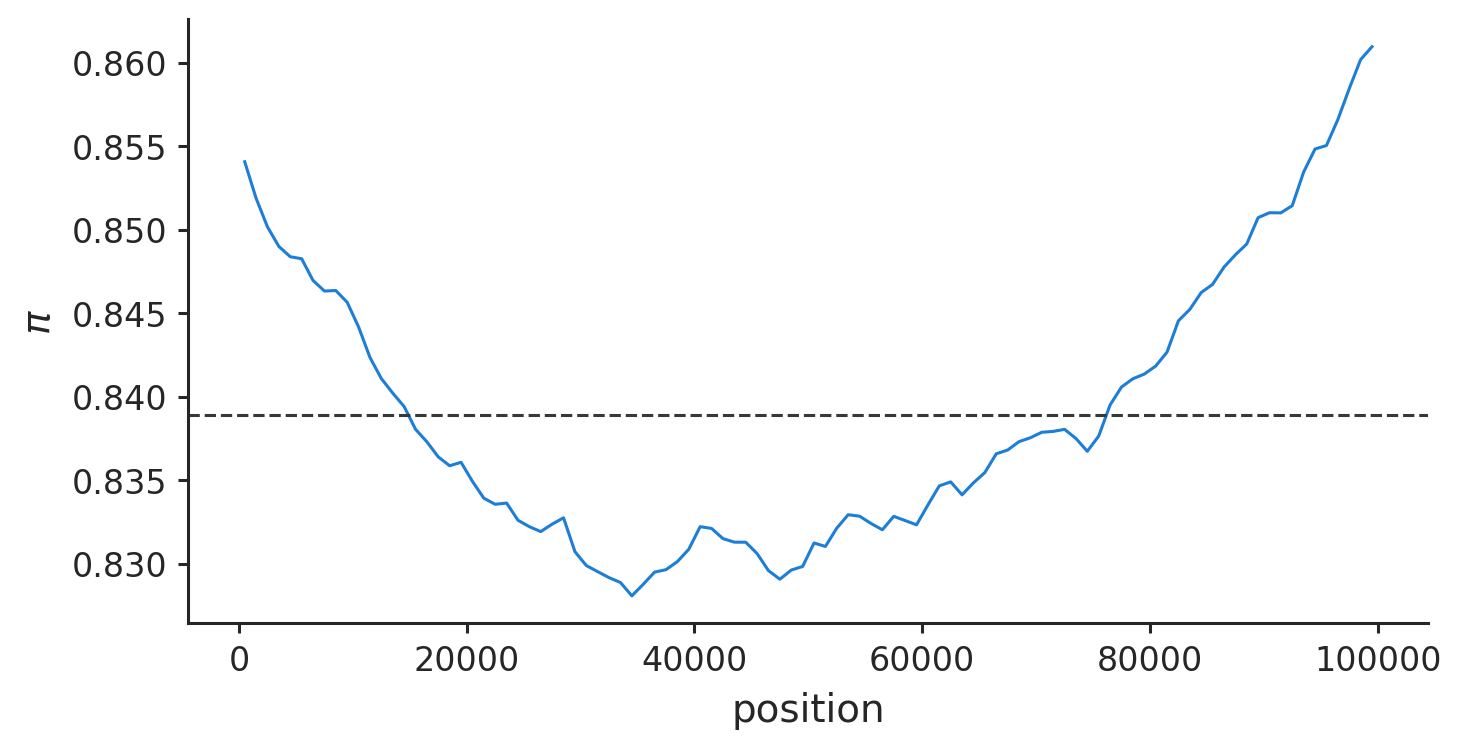

In [6]:
midpoints = (bins[1:] + bins[:-1])/2
plt.plot(midpoints, np.stack(pi).mean(axis=0)/(4*N))
plt.axhline(np.mean(pi)/(4*N), c='0.22', linestyle='dashed')
plt.ylabel("$\pi$")
plt.xlabel("position")

## Analysis of Simulation Results

In [7]:
d = pd.read_pickle('../data/slim_sims/region/region_results.pkl')
d.head()

,generation,k_mean,k_sd,k3,k4,f_mean,f_sd,f3,f4,s,...,B_middle,ratchet,sh,N,rbp,mu,U,r2sum,ldsum,ldn
0,9991,5.672,2.164050,0.260849,47.444700,0.998209,0.000683,-7.906440e-12,4.702630e-13,2,...,0.698212,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000316,1000,1.000000e-08,1.000000e-08,0.001000,9.089089,0.433346,34
1,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,0.853508,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000010,1000,1.000000e-08,1.000000e-10,0.000010,0.000000,0.000000,0
2,9991,0.000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0,...,0.769276,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000032,1000,1.000000e-08,3.160000e-10,0.000032,0.000000,0.000000,0
3,9991,0.001,0.031623,0.000997,0.000996,0.999900,0.003162,-9.970020e-07,9.960060e-08,0,...,1.156344,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.100000,1000,1.000000e-08,3.160000e-10,0.000032,0.000000,0.000000,0
4,9991,0.355,0.532220,0.170893,0.260478,0.999965,0.000053,-1.708930e-13,2.604780e-17,4,...,0.387827,"[[1, 0], [11, 0], [21, 0], [31, 0], [41, 0], [...",0.000100,1000,1.000000e-08,1.000000e-09,0.000100,0.000127,-0.000102,6


In [8]:
# average across replicates
dg = d.groupby(['sh', 'rbp', 'N', 'mu', 'U']).mean().reset_index()

In [9]:
dg['sh'].unique(), dg['mu'].unique(), dg['rbp'].unique()

(array([1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04, 1.00e-03, 3.16e-03,
        1.00e-02, 3.16e-02, 1.00e-01]),
 array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]),
 array([1.e-08]))

### Validation of Equations

/home/vsb/projects/bprime/bgspy/theory2.py:186: RuntimeWarning: overflow encountered in double_scalars
  (-1 + np.exp(((-(k*(M-2)) + M)*T)/2.))**2)/
/home/vsb/projects/bprime/bgspy/theory2.py:182: RuntimeWarning: overflow encountered in double_scalars
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:182: RuntimeWarning: overflow encountered in exp
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:182: RuntimeWarning: invalid value encountered in double_scalars
  integrand = (-(((np.expm1(k*T)**2)/(np.exp(2*k*T)*k) +
/home/vsb/projects/bprime/bgspy/theory2.py:185: RuntimeWarning: invalid value encountered in double_scalars
  ((-2*np.exp(k*(M-2)*T - M*T) *
/home/vsb/projects/bprime/bgspy/theory2.py:186: RuntimeWarning: overflow encountered in exp
  (-1 + np.exp(((-(k*(M-2)) + M)*T)/2.))**2)/
/home/vsb/projects/bprime/bgspy/theory2.py:182: RuntimeWarning: overflow encountered in expm1
  in

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


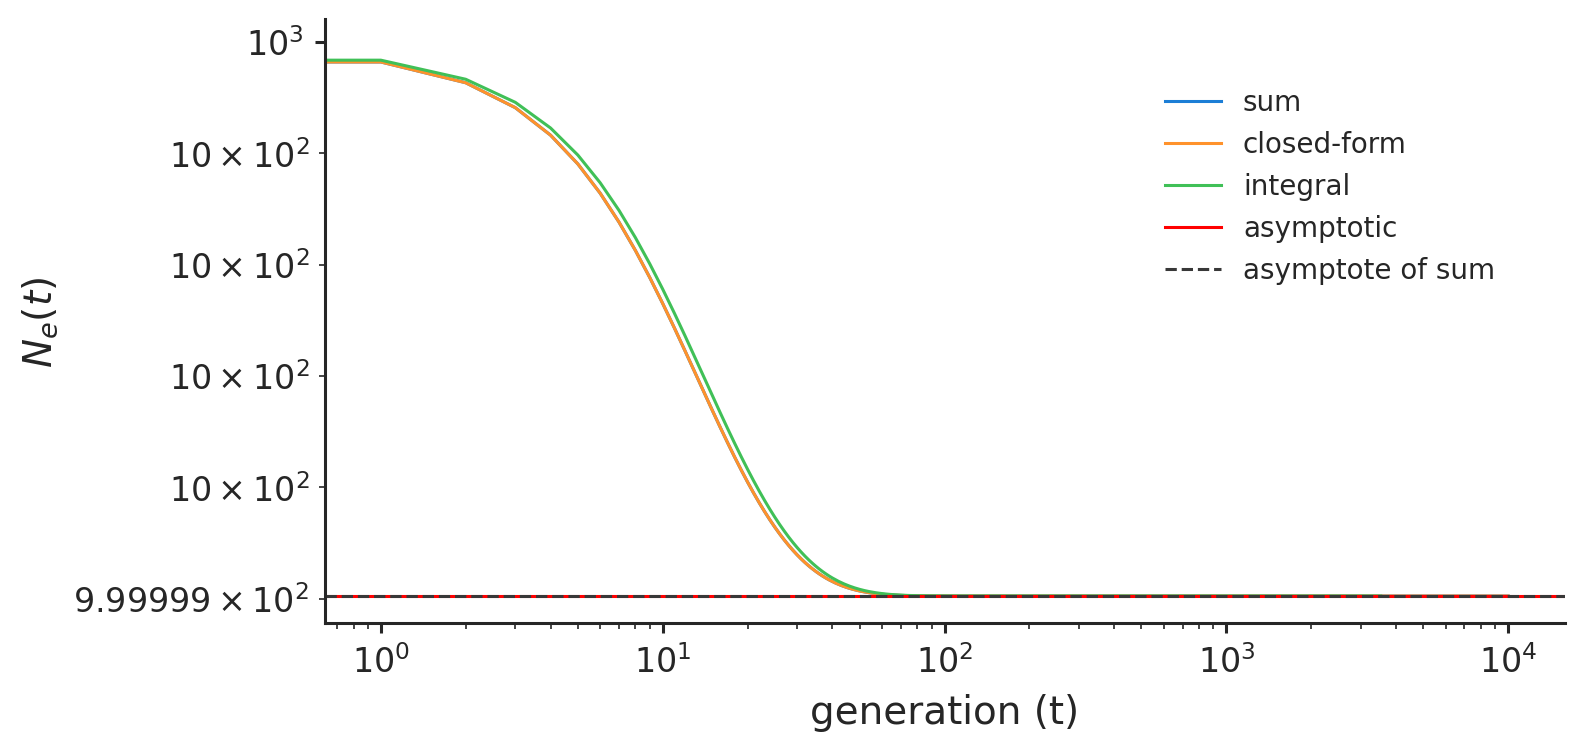

In [10]:
# some test parameters
V = 1e-8
Vm = 0.1*V
R = rbp*L
Z = 1-Vm/V
plt.plot(N*np.exp(-V/2*Q2_sum_integral(Z, R, 10000, use_sum=True)), label='sum')
plt.plot(N*np.exp(-V/2*Q2_sum_integral(Z, R, 10000, use_sum=False)), label='closed-form')
plt.plot(N*np.exp(-V/2*Q2_sum_integral2(Z, R, 10000)), label='integral')
plt.axhline(N*np.exp(-V/2 * Q2_asymptotic(Z, R)), c='r', label='asymptotic')
plt.axhline(N*np.exp(-V/2* Q2_sum_integral(Z, R)[-1]), c='0.22', label='asymptote of sum', linestyle='dashed')
plt.loglog()
plt.ylabel("$N_e(t)$")
plt.xlabel("generation (t)")
plt.legend()

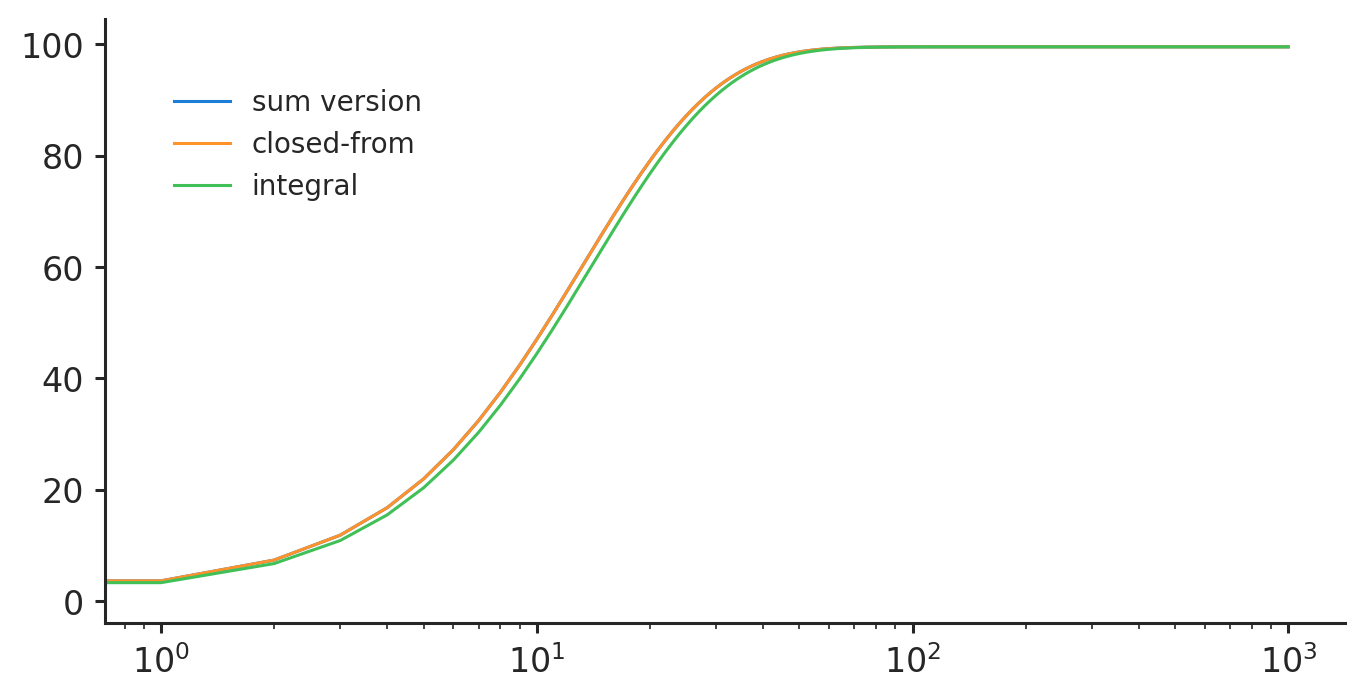

In [11]:
plt.plot(Q2_sum_integral(Z, R, use_sum=True), label='sum version')
plt.plot(Q2_sum_integral(Z, R, use_sum=False), label='closed-from')
plt.plot(Q2_sum_integral2(Z, R), label='integral')
#plt.axline((0, 0), slope=1, c='r', linestyle='dashed')
plt.semilogx()
plt.legend()

## Approximating the segment calculations

We pre-compute the $V$ and $V_m$ for each segment using the regional calculations. Then, we use these $V$ and $V_m$ values in a non-regional equation (just $r$), e.g. 

$$
Q(t) = \sum_{i=0}^t (1-r)^i (1-V_m/V)^i
$$

Then, $N_e(t) = N \exp(-V/2 Q(t)^2$ and the $B$ estimate is 

$$
2N B = \sum_{t = 0}^\infty \prod_{i=0}^t \left(1- \frac{1}{2N_e(t)}\right)
$$

This sum takes many elements to converge. 

In [29]:
# some example Qs -- should be very close after 100k gens
Qr_fixed(100_000, 1e-8, 1e-9, 1e-3), Qr_asymp(1e-8, 1e-9, 1e-3)

(9.910802775024777, 9.910802775024777)

How does the asymptotic $N_e$ differ from $N_e(t)$?

Note: $Q(t)$ only depends on a compound parameter $a = (1-r)(1-\kappa)$, where $\kappa = V_m/V$. So these can be combined (the functions with this alternate simpler parameteriztion of $V$ and $a$ have names that end in 2.

In [34]:
# some params
a = np.sort(1-np.logspace(-8, -3, 50))
Vs = np.logspace(-10, -7, 4)

In [35]:
# Are the C and Python versions giving us the same answers?

In [46]:
python = Ne_t_full2(N, Vs.mean(), a)

In [47]:
C = Ne_t(a, Vs.mean(), N)

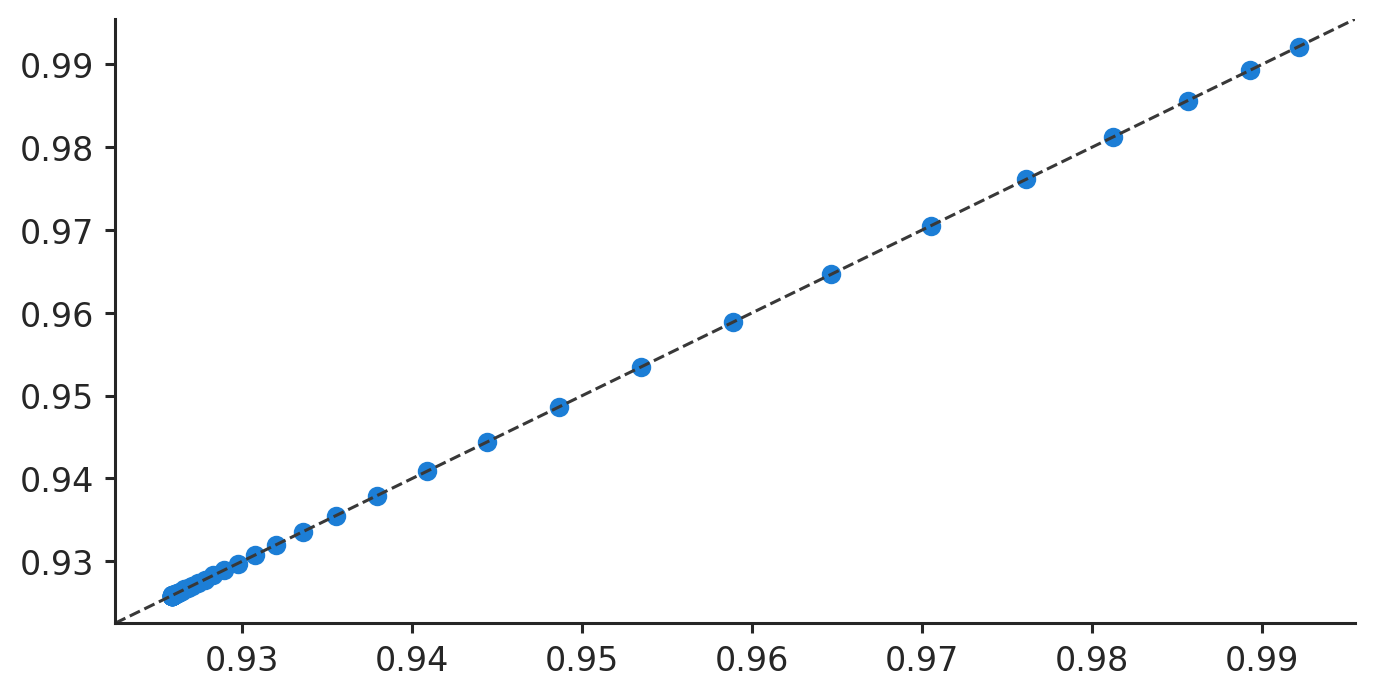

In [54]:
plt.scatter(python/N, C/N)
plt.axline((0.99, 0.99), slope=1, c='0.22', linestyle='dashed')


How big is the difference between asymptotic $N_e$ and $N_e(t)$?

In [170]:
grid = np.meshgrid(a, Vs)

In [171]:
asymp = Ne_asymp2(*grid, N)/N
real = Ne_t(*grid, N)/N
bias = asymp - real 

In [172]:
asymp.shape

(4, 50)

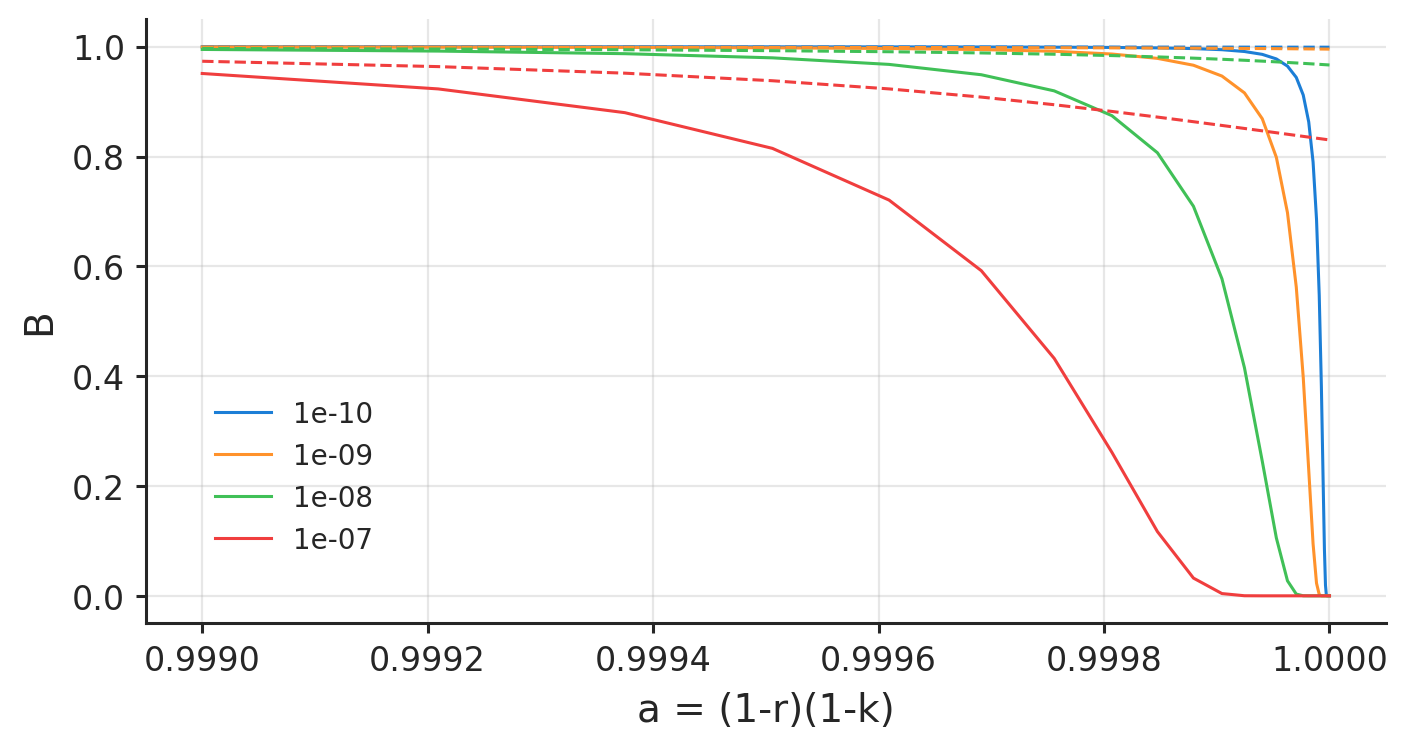

In [173]:
plt.plot(a, asymp.T, label=Vs)
plt.gca().set_prop_cycle(None)
plt.plot(a, real.T,  linestyle='dashed')
plt.grid()
plt.ylabel("B")
plt.xlabel("a = (1-r)(1-k)")
plt.legend()

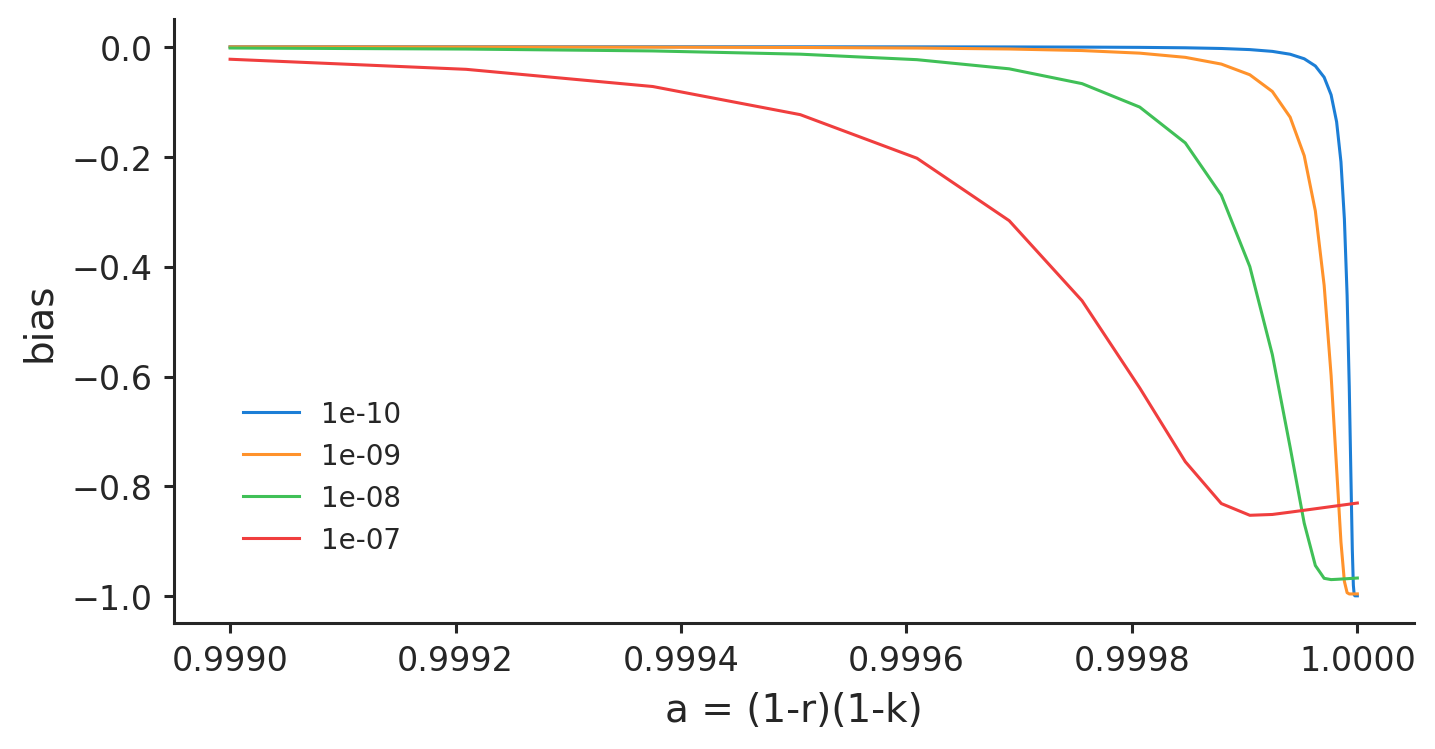

In [99]:
plt.plot(a, bias.T, label=Vs)
plt.ylabel("bias")
plt.xlabel("a = (1-r)(1-k)")
plt.legend()

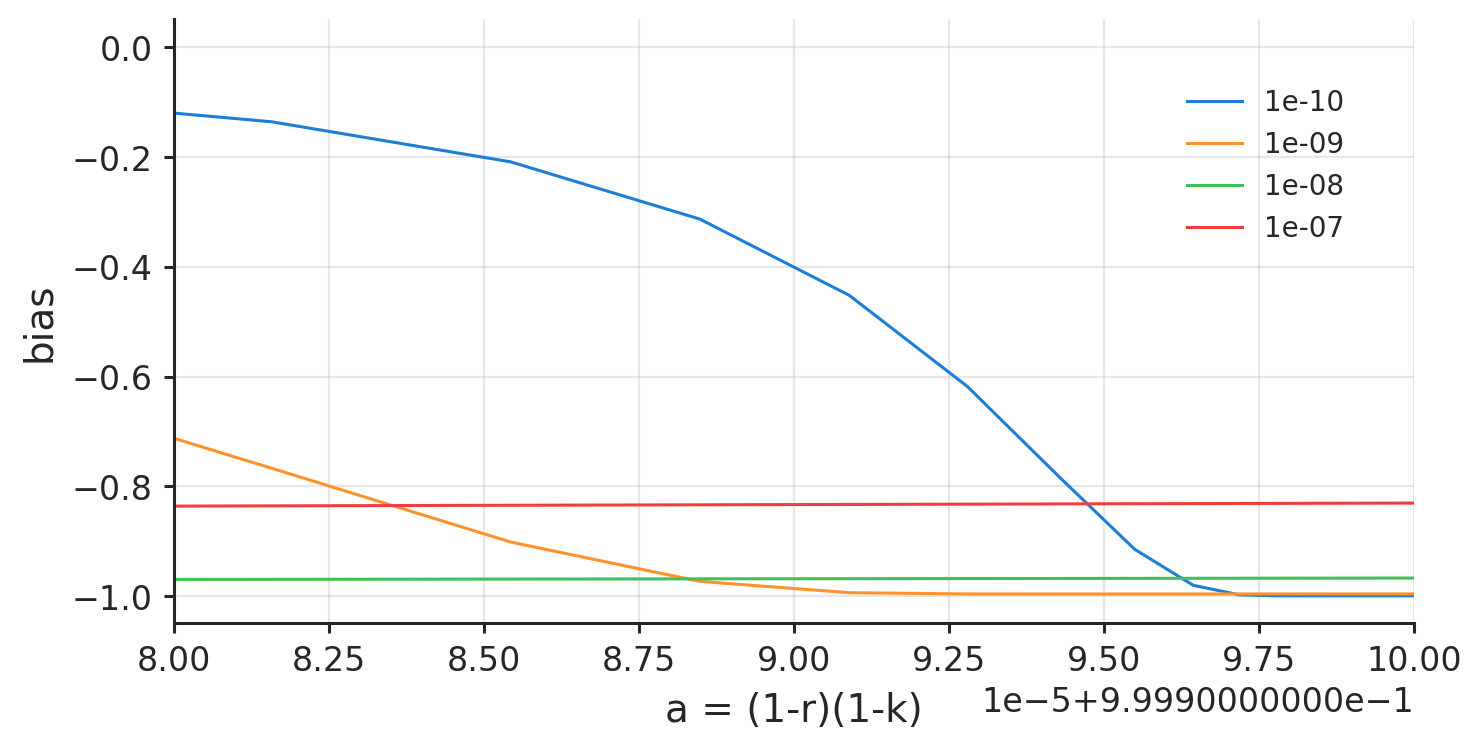

In [114]:
plt.plot(a, bias.T, label=Vs)
plt.ylabel("bias")
plt.xlabel("a = (1-r)(1-k)")
plt.legend()
plt.xlim(0.99998, 1)
plt.grid()

Now let's build an bias interpolator. There are two options in scipy, `interpn()` and `RegularGridInterpolator()`

In [179]:
# big grid
a_grid = np.sort(1-np.logspace(-8, -3, 100))
V_grid = np.logspace(-10, -7, 100)
interp_grid = np.meshgrid(a_grid, V_grid)

In [183]:
interp_asymp = Ne_asymp2(*interp_grid, N)/N
interp_real = Ne_t(*interp_grid, N)/N
interp_bias = interp_asymp - interp_real 

In [180]:
fun = RegularGridInterpolator((a_grid, V_grid), interp_bias.T, method='linear')

In [ ]:
bias = fun()

In [184]:
linear = []
spline = []
reggrid = []
for i in range(1000):
    ra, rV = np.random.uniform(a.min(), a.max()), np.random.uniform(V.min(), V.max())
    linear.append(interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='linear'))
    spline.append(interpn((a_grid, V_grid), interp_bias.T, (ra, rV), method='splinef2d'))
    reggrid.append(fun((ra, rV)))

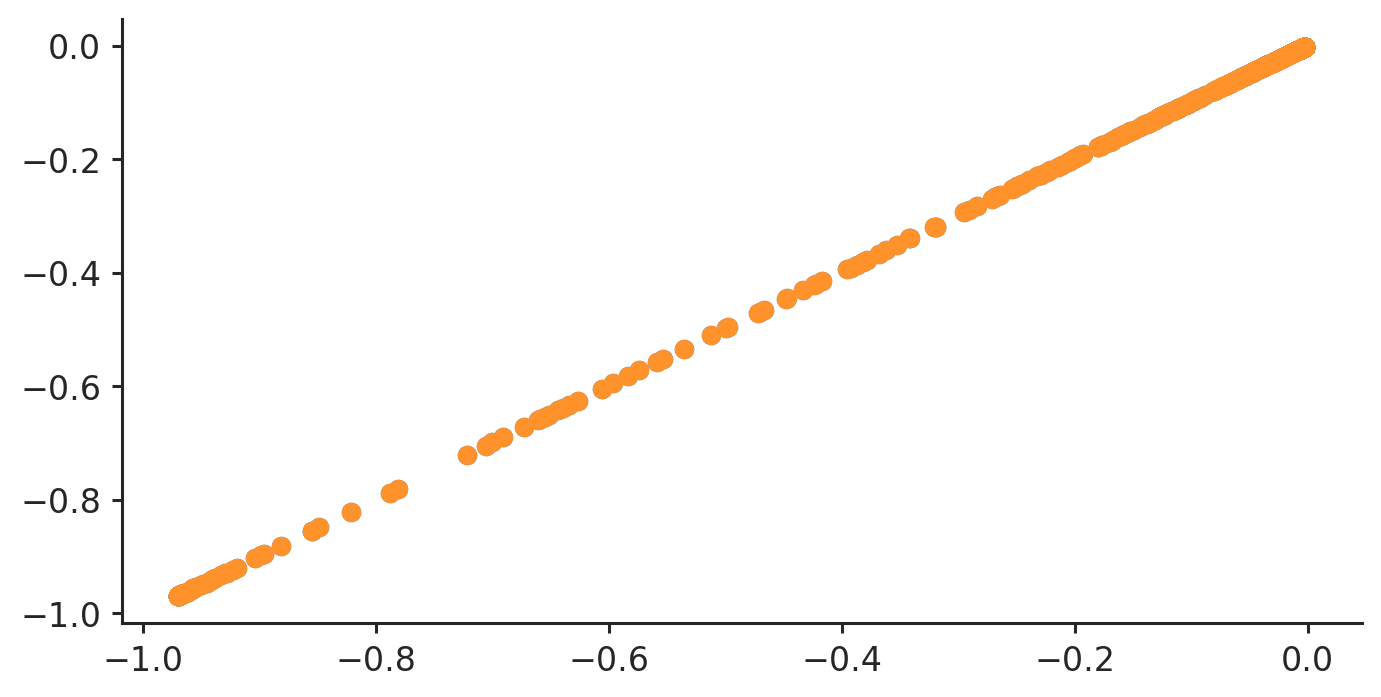

In [185]:
plt.scatter(linear, spline)
plt.scatter(reggrid, spline)

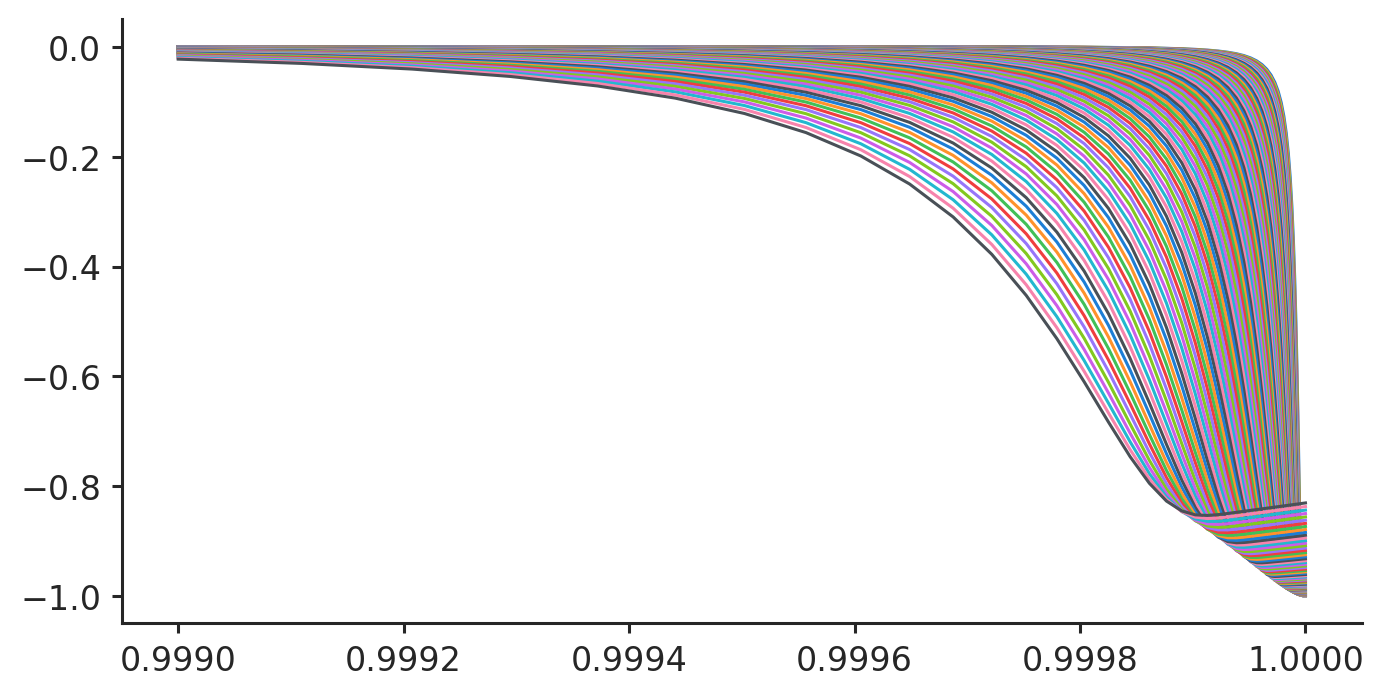

In [186]:
_ =plt.plot(a_grid, interp_bias.T)

## Comparing Simulations to Theory

Pre-compute all the theory data, for the regional simulations.

In [669]:
theory_data = dict()

x = np.logspace(-5, 1, 100)
for mu in dg['mu'].unique():
    parts = np.array(bgs_segment_sc16_parts(mu, x, L, rbp, N))
    Bs = np.array([x[0] for x in parts])
    Bs_asymp = np.array([x[1] for x in parts])
    other_stuff = [x[5:] for x in parts]
    classic_bgs = np.array([x[-1] for x in parts])
    Vs = np.array([x[3] for x in parts])
    Vms = np.array([x[4] for x in parts])    
    Ts = np.array([x[2] for x in parts])
    theory_data[mu] = x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff
    

/home/vsb/projects/bprime/bgspy/theory2.py:101: RuntimeWarning: overflow encountered in exp
  out = (np.exp(4*sh*Ne) - 1)/(2*U*sh*Ne)
/home/vsb/projects/bprime/bgspy/theory2.py:246: RuntimeWarning: invalid value encountered in double_scalars
  return [np.log(new_T) - np.log(T),


(0.0015, 100)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


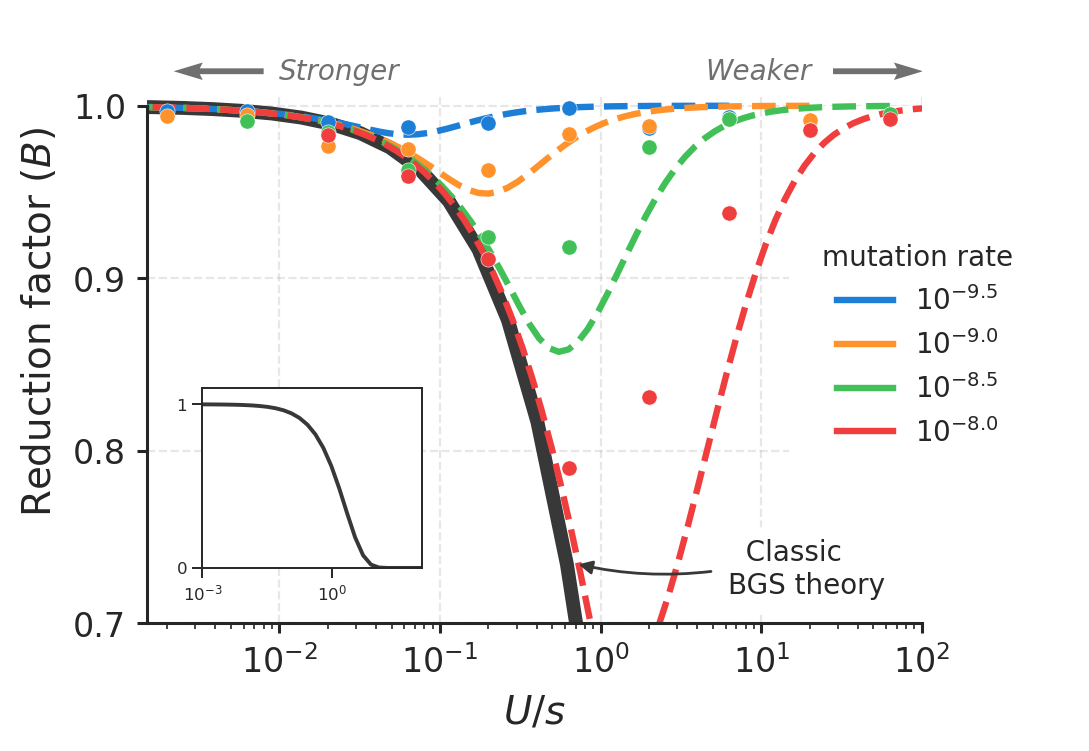

In [671]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def B_theory_plot(sim_dg, L, rbp, N, mus=None, x=np.logspace(-5, np.log10(0.9), 50), 
                  include_asymp=True, labels=True, xlim=None, ylim=None, 
                  marker_size=5, linewidth=2, data=None,
                  bgs_linewidth=2, bgs_zorder=10, figax=None, **figax_kwargs):
    fig, ax = get_figax(figax, **figax_kwargs)
    if mus is None:
        mus = sim_dg['mu'].unique()
    for mu in mus:
        dgs = sim_dg.loc[dg['mu'] == mu]

        U = 2*mu*L
        mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
        
        # sim data
        sh = dgs['sh'].values
        rate = U/sh
        col = next(ax._get_lines.prop_cycler)['color']
        ax.scatter(rate, dgs['B_middle'], edgecolor='white', linewidth=0.2, c=col, s=marker_size, zorder=10)

        # theory part
        if data is None:
            # calculate the values directly
            Bs_asymp = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False))
            Bs = np.array(bgs_segment_sc16_vec(mu, x, L, rbp, N, dont_fallback=False, asymptotic=False, sum_n=10))
        else:
            # use pre-calc'd dict
            x, Bs, Bs_asymp, Vs, Ts, classic_bgs, other_stuff = data[mu]
        #Bs = np.array(bgs_segment_sc162(mu, x2, L, rbp, 1000, asymptotic=False, sum_n=10))
        #plt.plot(U/x, Bs_asymp, label=mu)

        if include_asymp:
            ax.plot(U/x, Bs_asymp, c=col, linestyle='dashed', linewidth=linewidth)
        #ax.plot(U/x, Bs, c=col, linewidth=linewidth, label=mu_label)
        ax.plot(U/x[~classic_bgs], Bs[~classic_bgs], c=col, linewidth=linewidth, label=mu_label)
        #ax.plot(U/x[classic_bgs], Bs[classic_bgs], c=col, linestyle=(0, (7, 2)), linewidth=linewidth)
        ax.plot(U/x[classic_bgs], Bs[classic_bgs], c=col, linewidth=linewidth)
    mu = max(mus)
    mu_x = np.logspace(-8, 1, 50)
    bgs_theory = bgs_rec(mu, mu_x, L, rbp)
    ax.plot(2*mu*L/mu_x, bgs_theory, c='0.22', linewidth=bgs_linewidth, zorder=bgs_zorder)
    
    ax.semilogx()
    if labels:
        ax.set_ylabel("B")
        ax.set_xlabel("U/s")
    if ylim is not None:
        ax.set_ylim(*ylim)
    if xlim is not None:
        print(xlim)
        ax.set_xlim(*xlim)
    else:
        ax.set_xlim(1e-3, 120)
    return fig, ax
    

plt.rcParams['text.usetex'] = False

    
fig, ax = plt.subplots(figsize=(5, 4))

axin = inset_axes(ax, width=1.1, height=0.9, loc=3, borderpad=2)

MUs = [3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08]

## MAIN CALLS
B_theory_plot(dg, L=L, rbp=rbp, N=N,
              mus=MUs,
              figax=(fig, ax), data=theory_data,
              xlim=(0.0015, 100), include_asymp=True,
              #ylim=(0.70, 1.005), 
              ylim=(0.70, 1.05), 
              marker_size=30, bgs_zorder=1,
              legend=True, bgs_linewidth=5, linewidth=2.3)
B_theory_plot(dg, L=L, rbp=rbp, N=N, 
              mus=MUs,
              figax=(fig, axin), data=theory_data,
              ylim=(0, 1.1), include_asymp=False, 
              legend=False, labels=False, bgs_zorder=-1, marker_size=0,
              bgs_linewidth=1.4, linewidth=1)

for item in ([axin.title, axin.xaxis.label, axin.yaxis.label] +
              axin.get_xticklabels() + axin.get_yticklabels()):
    item.set_fontsize(6)

axin.tick_params(axis="y", direction="out", pad=2)
axin.tick_params(axis="x", direction="out", pad=2)
axin_axeswidth = 0.7
for spine in ['top', 'right', 'left', 'bottom']:
    axin.spines[spine].set_visible(True)
    axin.spines[spine].set_linewidth(axin_axeswidth)
axin.xaxis.set_tick_params(width=axin_axeswidth)
axin.yaxis.set_tick_params(width=axin_axeswidth)
    
# draw the box around zoomed-in region
draw_box = False
if draw_box:
    x, y = ax.axes.get_xlim(), ax.axes.get_ylim()
    zoom = mpl.patches.Rectangle((x[0], y[0]), x[1] - x[0], y[1] - y[0], 
                                 linewidth=0.1, edgecolor='0.22', facecolor='none')
    axin.add_patch(zoom)

#ax.axhline(1, linestyle='dashed', c='0.22', linewidth=1, zorder=-1)
#axin.axhline(1, linestyle='dashed', c='0.22', linewidth=0.5, zorder=-1)

leg = ax.legend(loc=(0.8, 0.2), fontsize=10, title="mutation rate", framealpha=1, facecolor='white')
frame = leg.get_frame()
frame.set_facecolor('blue')
ax.text(0.01, 1.015, "Stronger", c='0.44', style='italic')
ax.quiver(0.008, 1.02, -0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.text(4.5, 1.015, "Weaker",  c='0.44', style='italic')
ax.quiver(28, 1.02, 0.9, 0, units='inches', scale_units='inches', scale=2, color='0.44', zorder=10)
ax.annotate("  Classic\nBGS theory", xy=(0.55, 0.1), xytext=(0.75, 0.05), 
            backgroundcolor='white', 
             arrowprops=dict(arrowstyle="-|>", color='0.22', relpos=(0., 0.5),
                            connectionstyle="arc3,rad=-0.1"),
            xycoords=ax.transAxes, weight=550)

ax.set_ylabel("Reduction factor ($B$)")
ax.set_xlabel("$U/s$")
ax.spines['left'].set_bounds((0.7, 1))
ax.grid(linestyle='dashed')
ax.set_axisbelow(True)
#axin.annotate("  Classic\nBGS theory", xy=(0.05, 0.1), fontsize=5)
ax.set_yticks([0.7, 0.8, 0.9, 1])

# mask the grid behind arrows
mask_grid_quiver = mpl.patches.Rectangle((0, 1.005), 100, 0.1, facecolor='white', zorder=1)
ax.add_patch(mask_grid_quiver)

# mask grid behind legend
mask_grid = mpl.patches.Rectangle((15, 0.2), 400, 0.8, facecolor='white', zorder=1)
ax.add_patch(mask_grid)

/tmp/ipykernel_7469/519526786.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


[Text(0, 0.01, '$\\mathdefault{10^{-2}}$N'),
 Text(0, 0.1, '$\\mathdefault{10^{-1}}$N'),
 Text(0, 1.0, '$\\mathdefault{10^{0}}$N'),
 Text(0, 10.0, '$\\mathdefault{10^{1}}$N'),
 Text(0, 100.0, '$\\mathdefault{10^{2}}$N'),
 Text(0, 1000.0, '$\\mathdefault{10^{3}}$N'),
 Text(0, 10000.0, '$\\mathdefault{10^{4}}$N')]

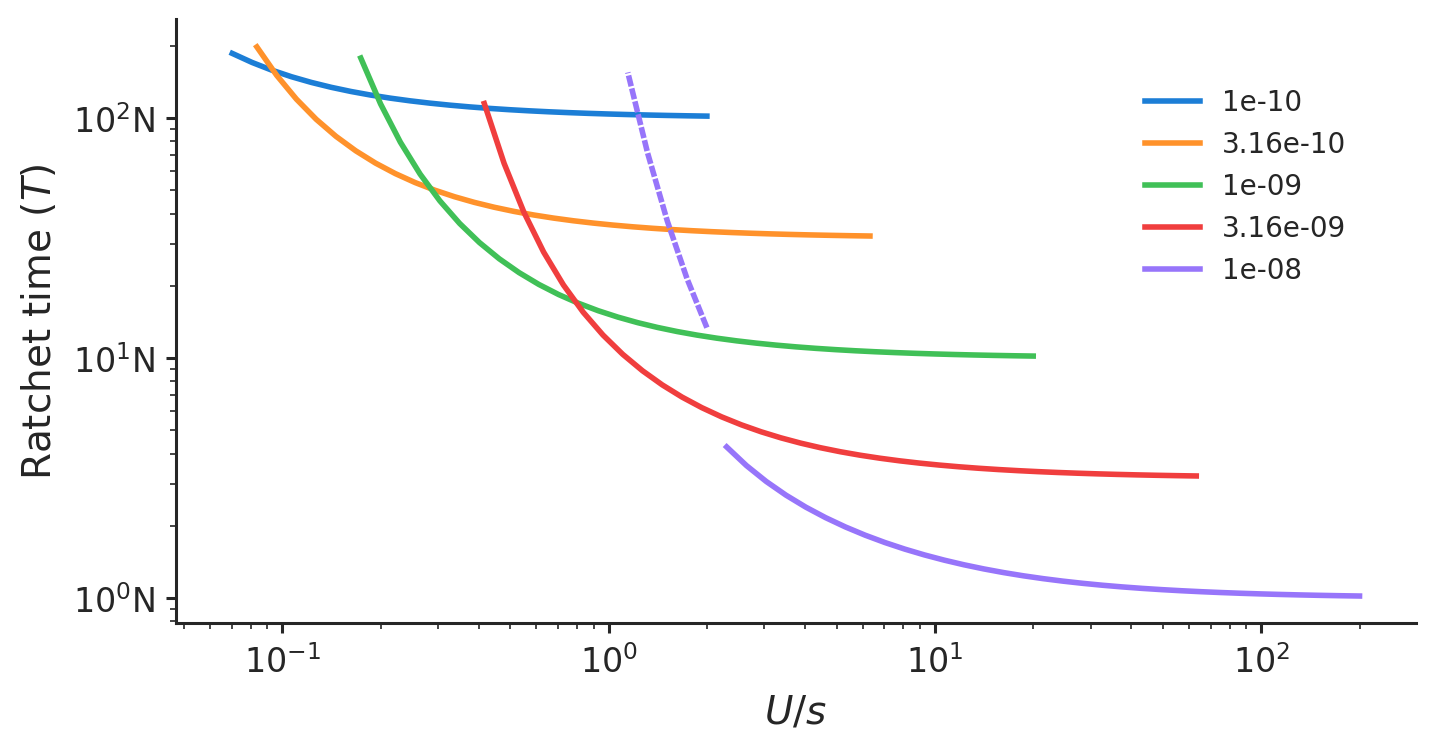

In [22]:
max_T = 200

fig, ax = plt.subplots()

for mu in theory_data.keys():
    s = theory_data[mu][0]
    T = theory_data[mu][4] / N
    classic_bgs = np.array([x[-1] for x in theory_data[mu][-1]])

    U = 2*mu*L

    # classic BGS theory
    keep = np.isfinite(T) & (T < max_T) & classic_bgs
    lines = ax.plot(U/s[keep], T[keep], linewidth=2, linestyle=(0, (2, 0.4)))

    # new theory
    keep = np.isfinite(T) & (T < max_T) & ~classic_bgs
    ax.plot(U/s[keep], T[keep], c=lines[0].get_color(), alpha=1, label=mu, linewidth=2)
ax.loglog()
ax.set_ylabel("Ratchet time ($T$)")
ax.set_xlabel("$U/s$")
fig.canvas.draw()
ax.legend()
labels = [x.get_text().replace('}}$', '}}$N') for x in ax.get_yticklabels()]
ax.set_yticklabels(labels)

In [278]:
def average_ratchet_rates(d):
    data = dict()
    for mu in d['mu'].unique():
        for sh in d['sh'].unique():
            # get the ratchet values
            M = d.loc[(d['sh'] == sh) & (d['mu'] == mu)]['ratchet'].values
            D = np.stack([x for x in M]) 
            D_mean = D.mean(axis=0)
            data[(mu, sh)] = D_mean
    return data
    
rate_data = average_ratchet_rates(d)


In [279]:
import statsmodels.api as sm

In [318]:
def ratchet_rate_estimate(data, buffer=9000):
    rates = dict()
    for mu, sh in data.keys():
        d = data[(mu, sh)]
        if buffer is not None:
            d = d[d[:, 0] > buffer, :]
        X = sm.add_constant(d[:, 0])
        y = d[:, 1]
        fit = sm.OLS(y, X).fit()
        R = fit.params[1]
        rates[(mu, sh)] = R
    return rates

rates = ratchet_rate_estimate(rate_data)

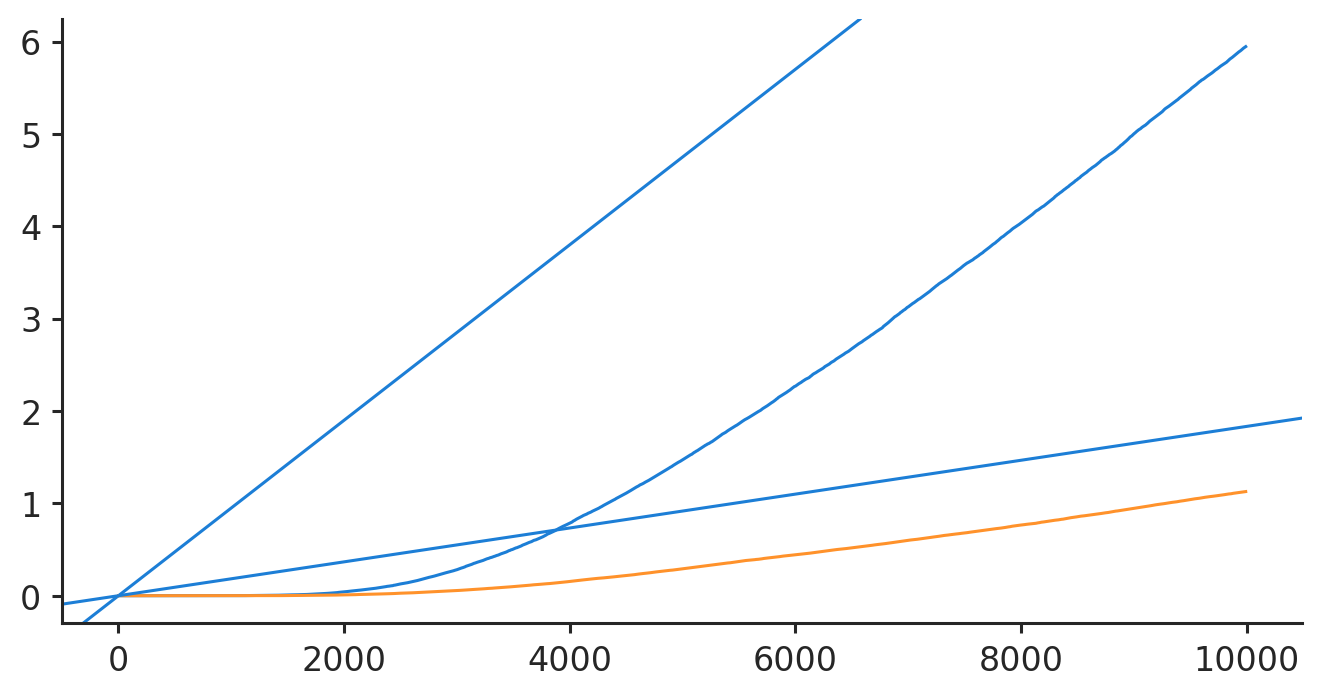

In [319]:
plt.plot(*rate_data[(1e-8, 1e-5)].T)
plt.axline((0, 0), slope=rates[(1e-8, 1e-5)])
plt.plot(*rate_data[(1e-8, 1e-3)].T)
plt.axline((0, 0), slope=rates[(1e-8, 1e-3)])


In [320]:
R_est

array([9.65721428e-04, 9.00857264e-04, 7.88967239e-04, 5.17448369e-04,
       1.84979772e-04, 1.46749419e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

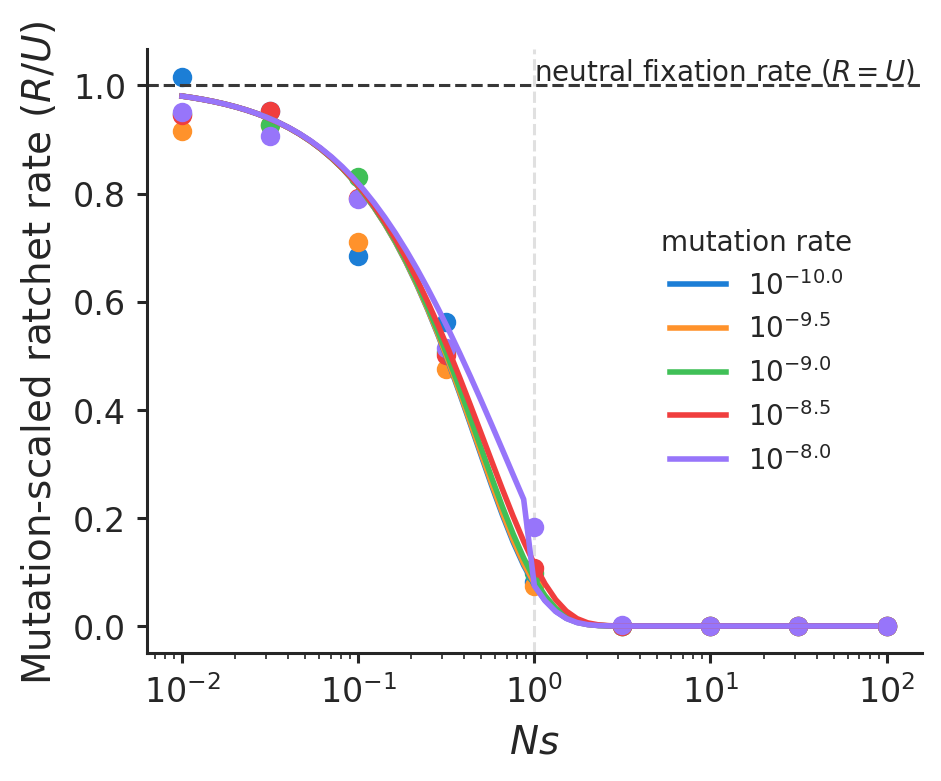

In [346]:
max_T = 100000

fig, ax = plt.subplots(figsize=(5, 4))

for mu in theory_data.keys():
    mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
    dgs = dg.loc[dg['mu'] == mu]
    U = 2*mu*L
    s = theory_data[mu][0] 
    T = theory_data[mu][4]
    R = 2/(T*U)
    col = next(ax._get_lines.prop_cycler)['color']
    keep = sN < 1e2
    ax.plot(N*s[keep], R[keep], c=col, alpha=1, linewidth=2, label=mu_label)
    
    R_est = np.array([rates[(mu, sh)] for sh in dgs['sh']])
    ax.scatter(dgs['sh']*N, 2*R_est/U, c=col)
ax.set_ylabel("Mutation-scaled ratchet rate ($R/U$)")
ax.set_xlabel("$Ns$")

fig.canvas.draw()
ax.legend(title="mutation rate")
ax.axhline(1, linestyle='dashed', c='0.22')
ax.annotate("neutral fixation rate ($R = U$)", (1, 1.01), xycoords='data')
ax.set_xscale('log')
ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')



/tmp/ipykernel_7469/2825154867.py:38: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(1e-7, 0)


Text(0.006, 3e-07, 'fitness variance\nlost due to ratchet')

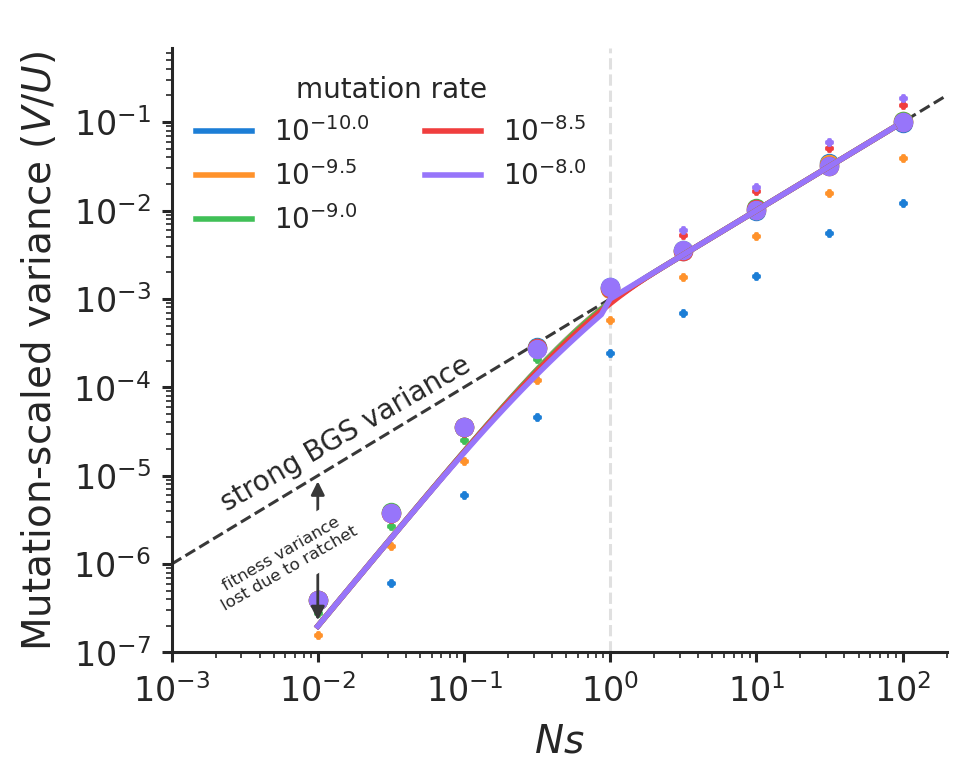

In [401]:
max_T = 100000

fig, ax = plt.subplots(figsize=(5, 4))

for mu in theory_data.keys():
    mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
    U = 2*mu*L
    sN = theory_data[mu][0] * N
    T = theory_data[mu][4]
    V = theory_data[mu][3] / U
    R =  1/T
    
    keep = sN < 1e2
    col = next(ax._get_lines.prop_cycler)['color']
    ax.plot(sN[keep], V[keep], linewidth=2,  label=mu_label, c=col)

    # new theory
    #ax.plot(sN, V, c=lines[0].get_color(), alpha=1, linewidth=2, label=mu_label)
    dgs = dg.loc[dg['mu'] == mu]
    # full fitness, including LD
    VA = dgs['f_sd']**2
    # genic fitness. k_mean is average of COUNT of mutations per diploid individual.
    Vf = dgs['sh']**2 * dgs['k_mean'] / 2
    ax.scatter(dgs['sh'] * N, Vf / (dgs['U']), c=col)
    ax.scatter(dgs['sh'] * N, VA / (dgs['U']), c=col, marker='P', s=4)
xs = np.logspace(-6, -0.5, 100)

ax.plot(xs*N, xs, zorder=-10, linestyle='dashed', c='0.22')
ax.annotate("strong BGS variance", (2e-3, 4e-6), xycoords='data', rotation=30)
ax.set_ylabel("Mutation-scaled variance ($V/U$)")
ax.set_xlabel("$Ns$")

ax.axvline(1, c='0.88', zorder=-10, linestyle='dashed')
fig.canvas.draw()
ax.legend(loc=(-0.04, 0.6), fontsize=10, ncol=2, title="mutation rate")
ax.loglog()
ax.set_xlim(1e-3, 2e2)
ax.set_ylim(1e-7, 0)
ax.annotate("$Ns = 1$", (1.1, 5e-8), xycoords='data', weight=550)
ax.annotate("", xy=(1e-2, 1e-5), xytext=(1e-2, 2e-7),
            xycoords='data', arrowprops=dict(color='0.22', arrowstyle='<|-|>'))
ax.annotate("fitness variance\nlost due to ratchet", (6e-3, 3e-7), horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=1, linewidth=0), 
            fontsize=6, rotation=30)

# ax.annotate("fitness variance\nlost due to ratchet", (8e-3, 1e-6), horizontalalignment='center',
#             bbox=dict(facecolor='white', alpha=1, linewidth=0), 
#             fontsize=4, rotation=0)

In [502]:
from scipy.integrate import quad, dblquad

@np.vectorize
def ok71(rho):
    return (10+rho) / (22 + 13*rho + rho**2)

@np.vectorize
def total_ld(rbp, N, L):
    R = rbp*L
    haldane = lambda m: 0.5*(1-np.exp(-m))
    return quad(lambda x: (1/R**2) * 2*(R-x) * ok71(4*N*haldane(x)), 0, R)[0]

n = 4*N*mu*L
(n * (n-1) + 1) * total_ld(mu, N, L)

4.588053322709864

In [541]:
(np.triu(np.arange(25).reshape(5, 5), k=1) > 0).sum()

10

In [540]:
n = 5
(n * (n-1)/2)

10.0

In [542]:
@np.vectorize
def neutral_ld(mu, rbp, N, L):
    # N is *diploid* pop size
    R = rbp * L
    #fun = lambda x: ok71(4*N*rbp*x) * (2-2*x) 
    haldane = lambda m: 0.5*(1-np.exp(-m))
    fun = lambda x: ok71(4*N*haldane(rbp*x)) * (1/L**2) * 2*(L-x)
    n = 4*N*mu*L
    return ((n * (n-1))/2) * integrate.quad(fun, 0, L)[0]

neutral_ld(mu, rbp, N, L)

array(2.11756307)

In [451]:
#d.groupby(['sh', 'mu']).mean()['ldn']

In [39]:
def force_infinite_sites(tr):
    bad_sites = np.array([int(x.id) for x in tr.sites() if len(x.mutations) > 1])
    if len(bad_sites) > 0:
        return tr.delete_sites(bad_sites)
    return tr


In [403]:
ld = dict()
for mu in theory_data.keys():
    lds = []
    for r in range(100):
        ts = msprime.sim_ancestry(samples=1000, population_size=1000, recombination_rate=1e-8, sequence_length=L)
        tsm = msprime.sim_mutations(ts, rate=mu)
        ld_calc = tsk.LdCalculator(force_infinite_sites(tsm))
        r2_sum = np.nansum(np.triu(ld_calc.r2_matrix(), k=1))
        lds.append(r2_sum)
    ld[mu] = np.mean(lds)

In [488]:
4*N*(1e-8*L)

4.0

[]

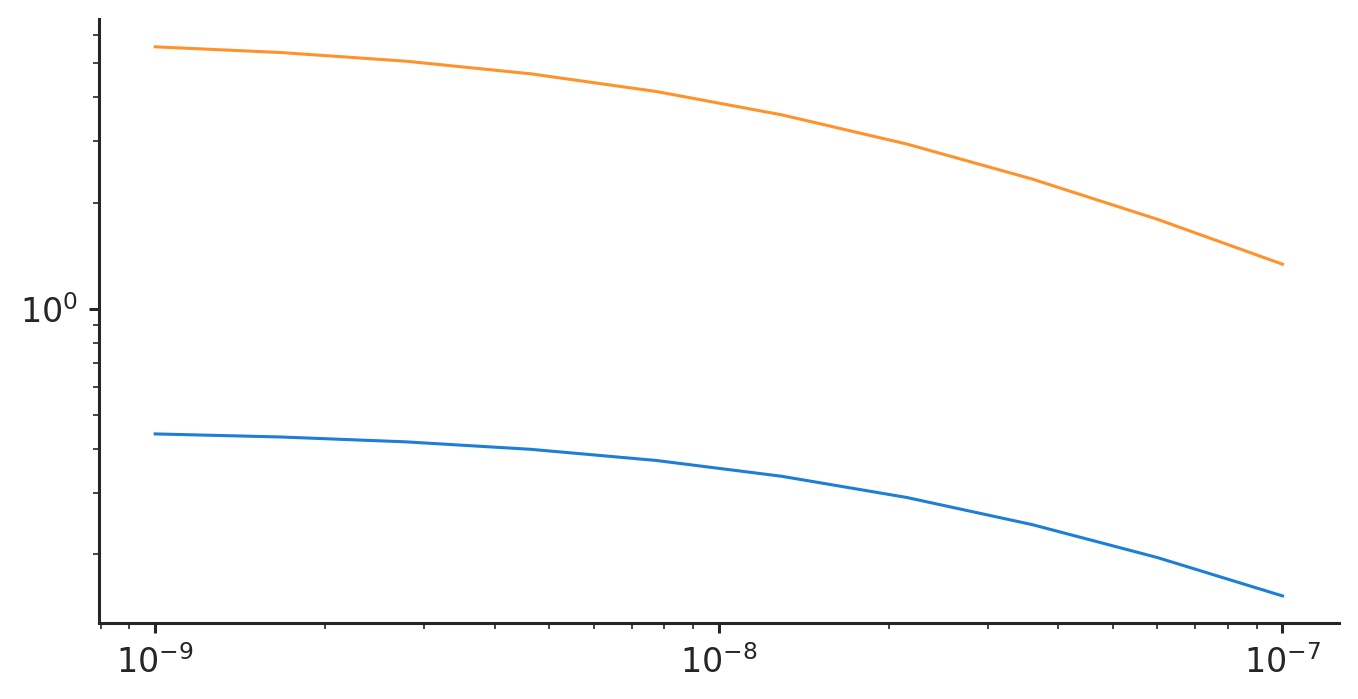

In [520]:
r = np.logspace(-9, -7, 10)
plt.plot(r, total_ld(r, N, L))
plt.plot(r, neutral_ld(mu, r, N, L))
plt.loglog()

[]

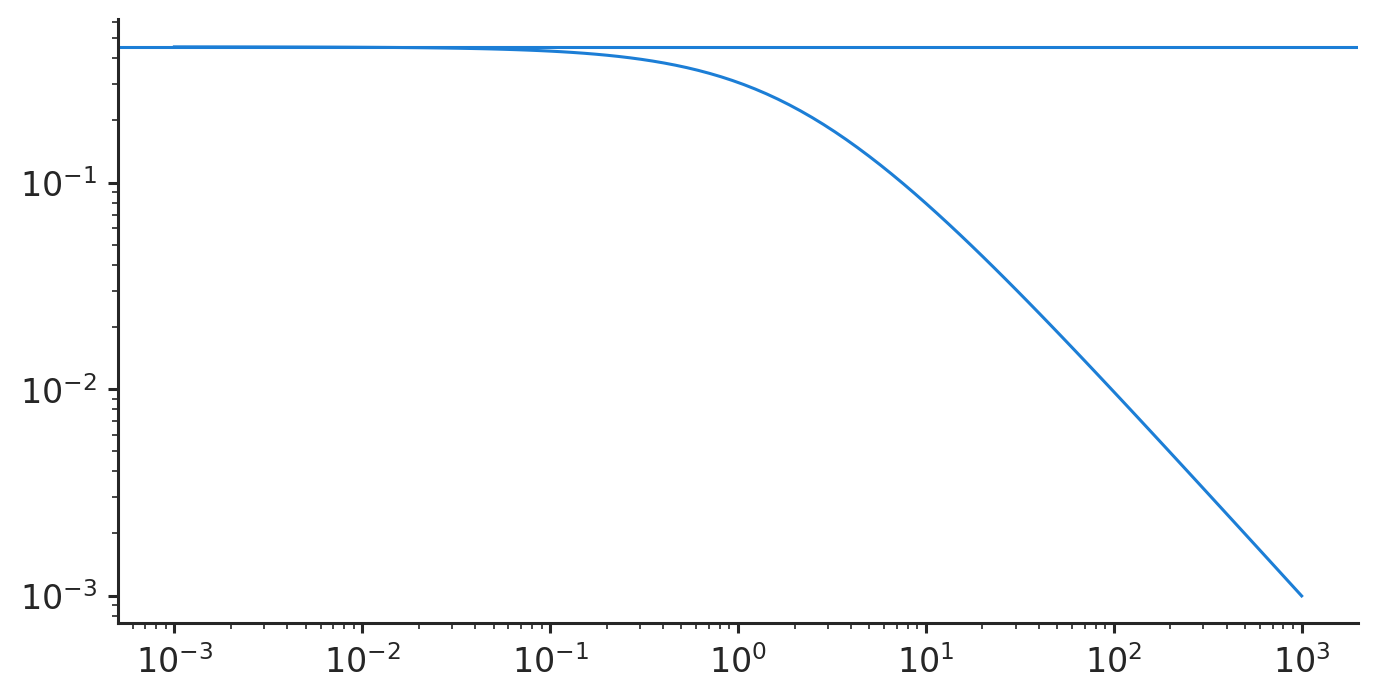

In [498]:
rho = np.logspace(-3, 3, 100)
plt.plot(rho, ok71(rho))
plt.axhline(ok71(0))
plt.loglog()

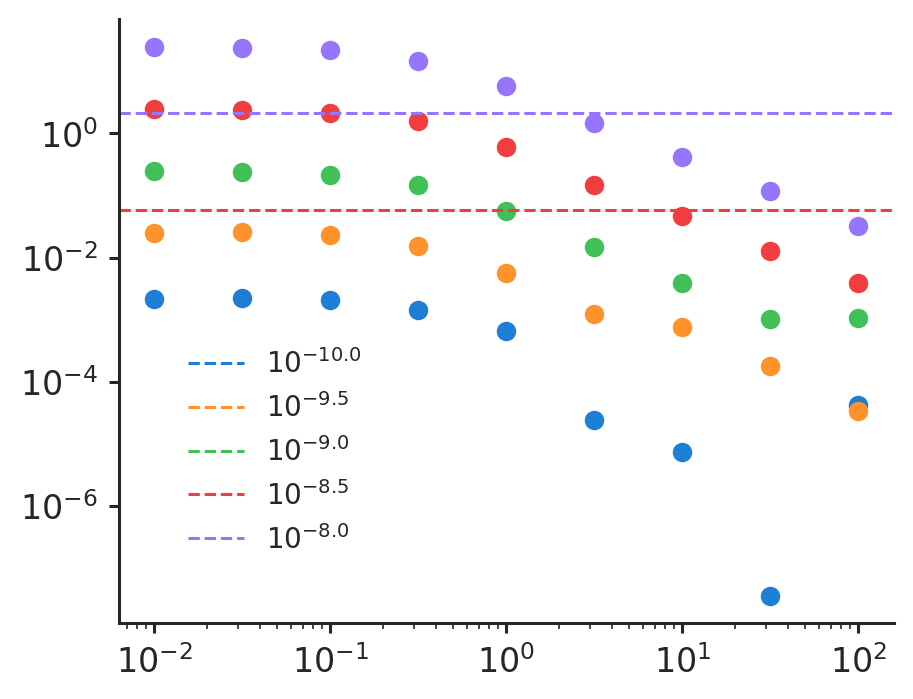

In [549]:

@np.vectorize
def total_ld(rbp, N, L):
    R = rbp*L
    haldane = lambda m: 0.5*(1-np.exp(-m))
    return quad(lambda x: (1/R**2) * 2*(R-x) * ok71(4*N*x), 0, R)[0]

fig, ax = plt.subplots(figsize=(5, 4))

for mu in theory_data.keys():
    mu_label = f"$10^{{{np.round(np.log10(mu), 2)}}}$"
    dgs = dg.loc[dg['mu'] == mu]
    U = 2*mu*L
    s = theory_data[mu][0] * N
    T = theory_data[mu][4]
    B = theory_data[mu][1]
    V = theory_data[mu][3] / U
    R =  1/T
    col = next(ax._get_lines.prop_cycler)['color']

    #Vp = [x[3] for x in bgs_segment_sc16_parts(mu, dgs['sh'], L, rbp, N)]
    S = dgs['ldn'].max()

    
    S = 4*N*mu*L
    xx = neutral_ld(mu, rbp, N, L)
    ax.axhline(xx, c=col, label=mu_label, linestyle='dashed')
    #ax.axhline(ld[mu], c=col, label=mu_label)
    ax.scatter(N*dgs['sh'], dgs['r2sum'], c=col)
    

#ax.loglog()
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [844]:
from scipy.integrate import quad

In [27]:
import msprime 

In [32]:
np.mean(lds)

0.00037266189763896776

In [958]:
r2_sum

7.304226513561803

# for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]
    sh = np.logspace(-5, -1, 100)
    plt.scatter(dgs['U']/dgs['sh'], dgs['k_sd']**2, label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    rate = dgs['U']/dgs['sh']
    plt.axline((0, 0), slope=1, c='0.22', linestyle='dashed')

plt.loglog()
plt.legend()
plt.xlabel("$U/s$")
plt.ylabel("Var(k)")

In [1997]:
plt.scatter(sc16_V, dg['theory_V'], c=np.log10(dg['r2sum']))
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.xlabel("SC '16 theoretic variance")
plt.ylabel('Us - sR') 
plt.colorbar(label="log10(R2 sum)")


NameError: name 'sc16_V' is not defined

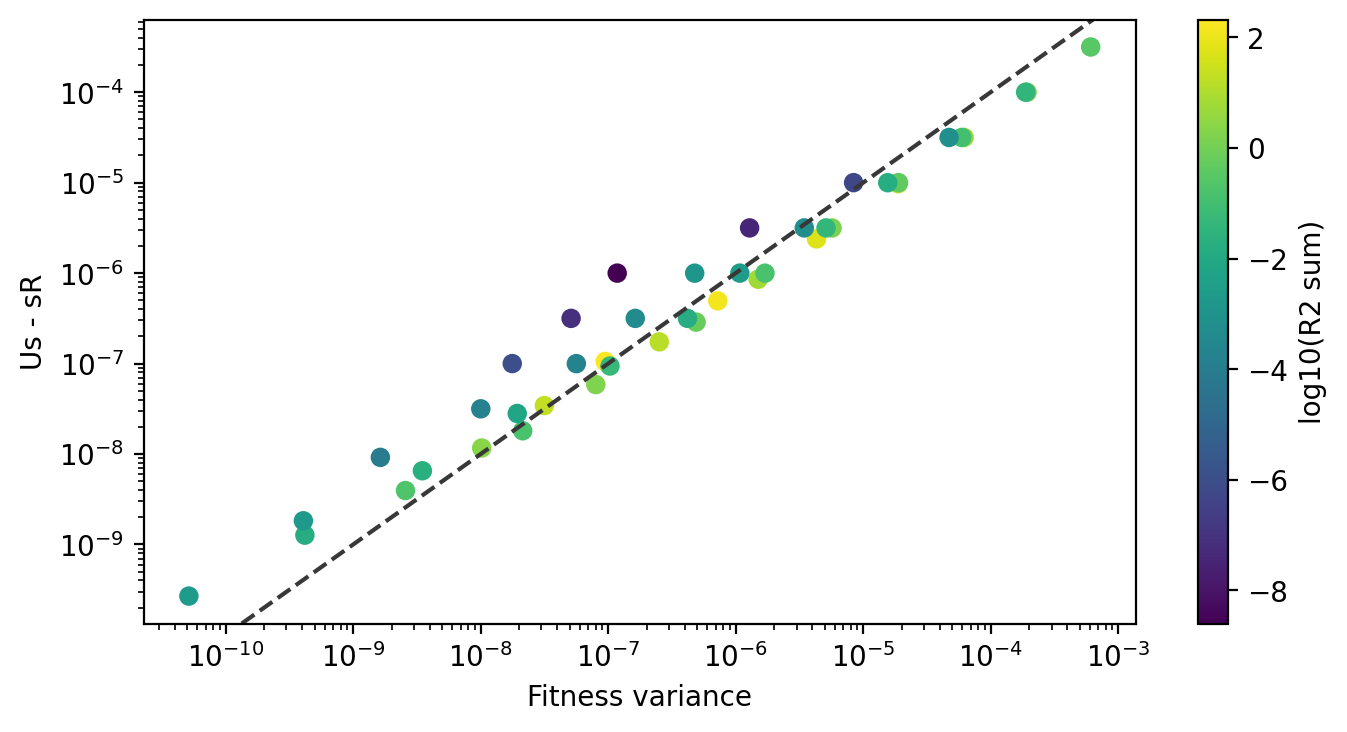

In [38]:
plt.scatter(dg['f_sd']**2, dg['theory_V'], c=np.log10(dg['r2sum']))
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.xlabel("Fitness variance")
plt.ylabel('Us - sR')
plt.colorbar(label="log10(R2 sum)")


[]

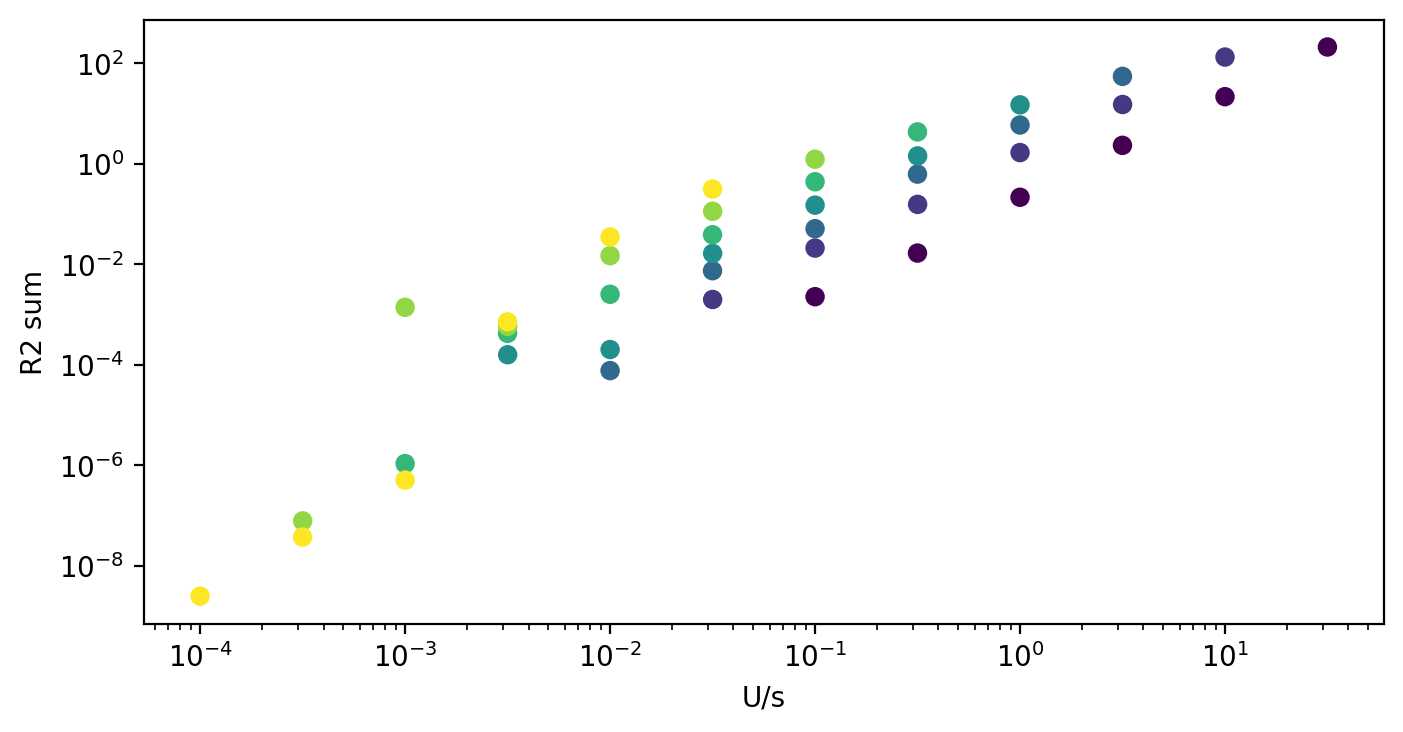

In [ ]:
plt.scatter(dg['U']/dg['sh'], np.abs(dg['r2sum']), c=np.log10(dg['sh']))
plt.xlabel("U/s")
plt.ylabel("R2 sum")
plt.loglog()

[]

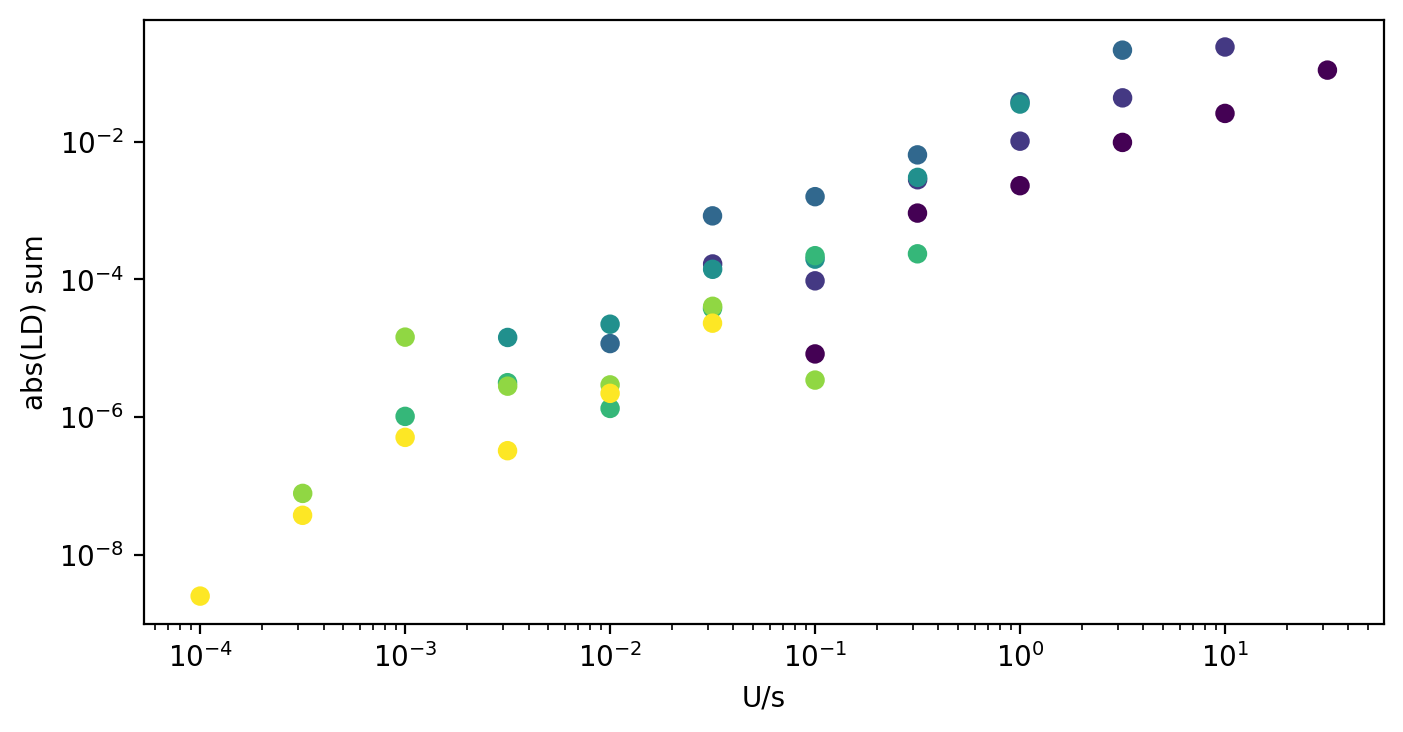

In [ ]:
plt.scatter(dg['U']/dg['sh'], np.abs(dg['ldsum']), c=np.log10(dg['sh']))
plt.xlabel("U/s")
plt.ylabel("abs(LD) sum")
plt.loglog()

[]

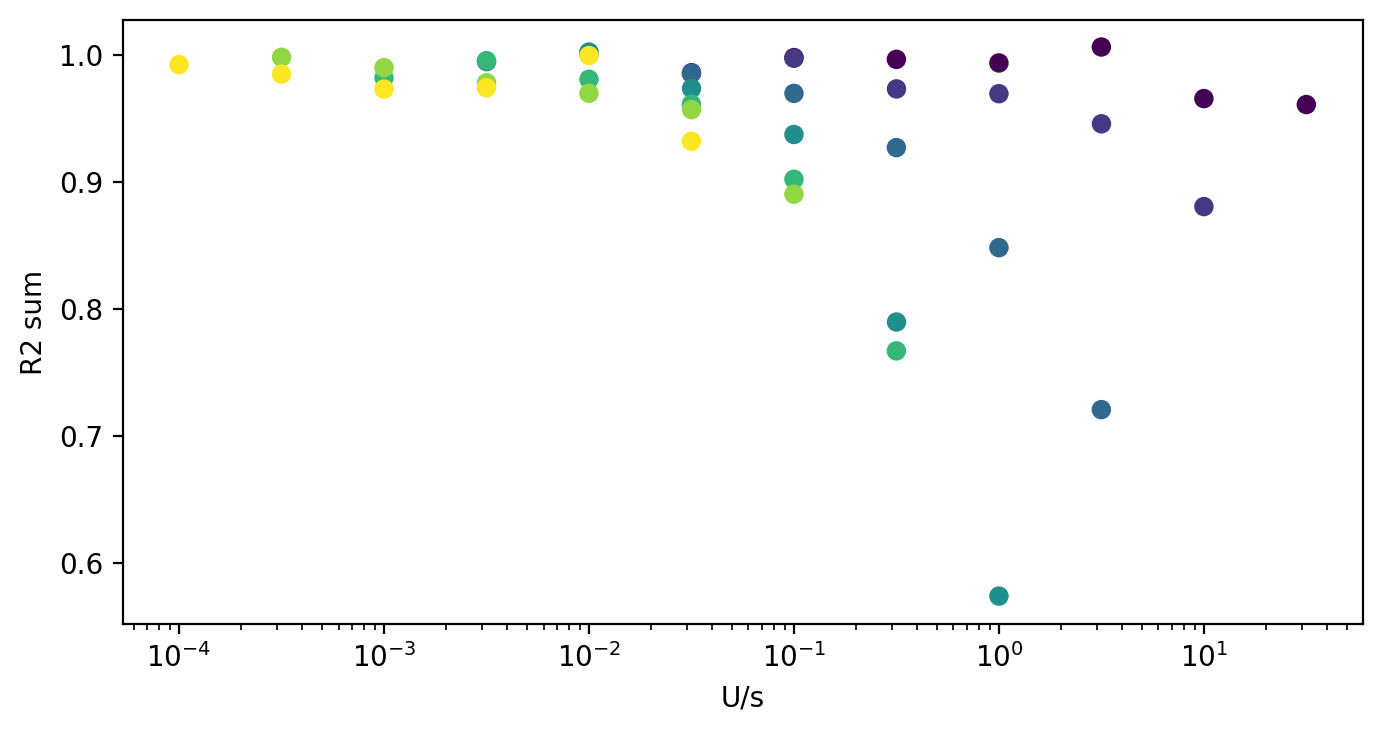

In [ ]:
plt.scatter(dg['U']/dg['sh'], dg['B'], c=np.log10(dg['sh']))
plt.xlabel("U/s")
plt.ylabel("R2 sum")
plt.semilogx()

Text(0.5, 0, 'U/s')

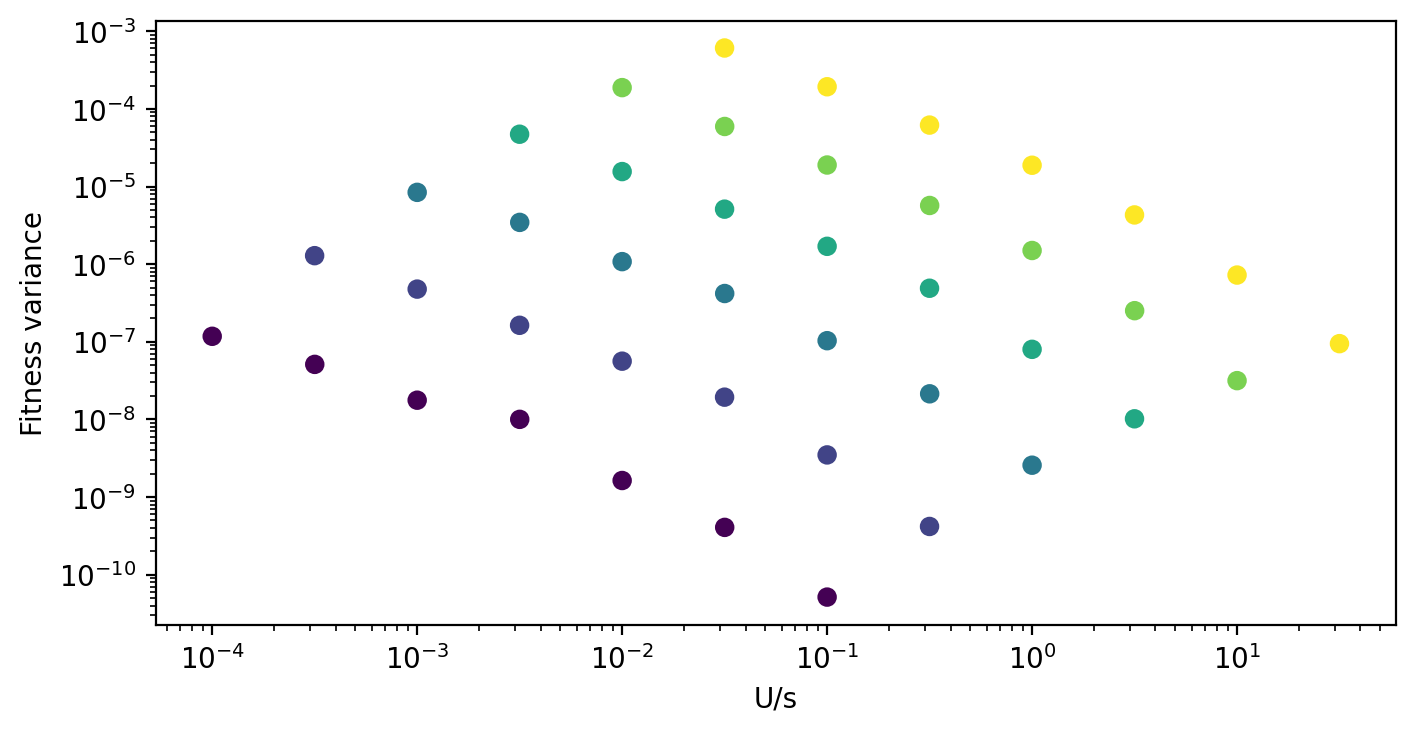

In [ ]:
plt.scatter(L*dg['mu']/dg['sh'], dg['f_sd']**2, c=np.log10(dg['mu']))
plt.loglog()
plt.ylabel("Fitness variance")
plt.xlabel('U/s')

In [56]:
mu, sh, L

(3.16e-08,
 array([1.00000000e-05, 1.09749877e-05, 1.20450354e-05, 1.32194115e-05,
        1.45082878e-05, 1.59228279e-05, 1.74752840e-05, 1.91791026e-05,
        2.10490414e-05, 2.31012970e-05, 2.53536449e-05, 2.78255940e-05,
        3.05385551e-05, 3.35160265e-05, 3.67837977e-05, 4.03701726e-05,
        4.43062146e-05, 4.86260158e-05, 5.33669923e-05, 5.85702082e-05,
        6.42807312e-05, 7.05480231e-05, 7.74263683e-05, 8.49753436e-05,
        9.32603347e-05, 1.02353102e-04, 1.12332403e-04, 1.23284674e-04,
        1.35304777e-04, 1.48496826e-04, 1.62975083e-04, 1.78864953e-04,
        1.96304065e-04, 2.15443469e-04, 2.36448941e-04, 2.59502421e-04,
        2.84803587e-04, 3.12571585e-04, 3.43046929e-04, 3.76493581e-04,
        4.13201240e-04, 4.53487851e-04, 4.97702356e-04, 5.46227722e-04,
        5.99484250e-04, 6.57933225e-04, 7.22080902e-04, 7.92482898e-04,
        8.69749003e-04, 9.54548457e-04, 1.04761575e-03, 1.14975700e-03,
        1.26185688e-03, 1.38488637e-03, 1.51991108e-0

In [58]:
bgs_segment_sc16(mu, sh, L, rbp, 2*N)

array([1999.99999995, 1999.99999994, 1999.99999993, 1999.99999991,
       1999.9999999 , 1999.99999987, 1999.99999985, 1999.99999982,
       1999.99999978, 1999.99999974, 1999.99999969, 1999.99999962,
       1999.99999955, 1999.99999946, 1999.99999935, 1999.99999922,
       1999.99999906, 1999.99999888, 1999.99999866, 1999.9999984 ,
       1999.99999808, 1999.99999771, 1999.99999727, 1999.99999675,
       1999.99999613, 1999.9999954 , 1999.99999453, 1999.99999352,
       1999.99999233, 1999.99999093, 1999.99998931, 1999.99998742,
       1999.99998523, 1999.99998271, 1999.99997982, 1999.99997653,
       1999.9999728 , 1999.99996861, 1999.99996395, 1999.99995879,
       1999.99995317, 1999.9999471 , 1999.99994063, 1999.99993386,
       1999.99992689, 1999.99991985, 1999.9999129 , 1999.99990621,
       1999.99989994, 1999.99989424, 1999.99988924, 1999.999885  ,
       1999.99988156, 1999.99987889, 1999.99987691, 1999.99987552,
       1999.99987459, 1999.999874  , 1999.99987365, 1999.99987

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.4, 1.05)

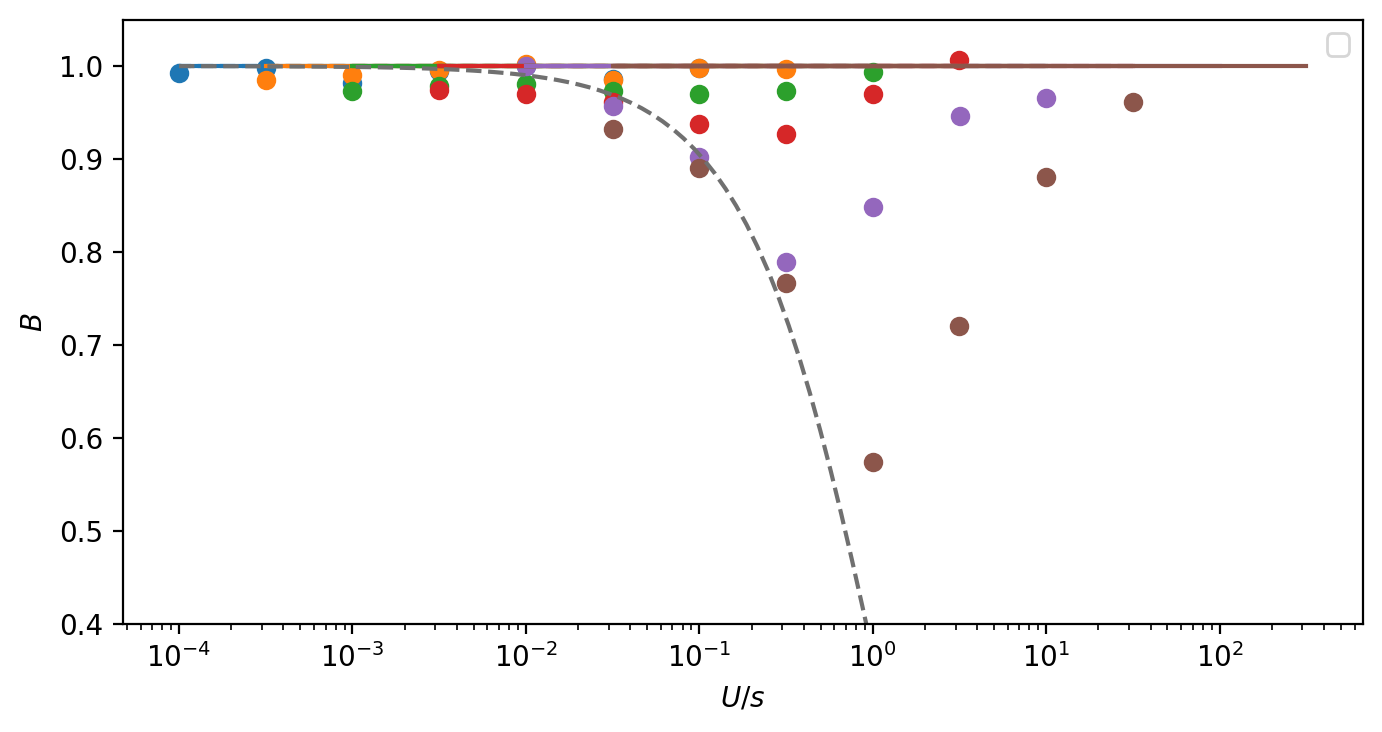

In [52]:
for mu in dg['mu'].unique():
    dgs = dg.loc[dg['mu'] == mu]
    sh = np.logspace(-5, -1, 100)
    #lines = plt.plot(mu/sh, bgs_segment_sc16p(mu, sh, L, rbp, N)/N, label=f"U = $10^{{{np.round(np.log10(mu), 2)}}}$")
    
    U = mu * L
    sh = dgs['sh'].values
    V = 2 * dgs['sh']**2 * dgs['ssh']
    #V = dgs['ssh'] * dgs['sh']**2 # dgs['f_sd']**2
    #V = dgs['f_sd']**2
    Vm = U*sh**2
    VmV = V/Vm
    Q2 = 1/(VmV * (VmV + L*rbp/2))
    res = bgs_segment_sc16(mu, sh, L, rbp, 2*N, return_both=True)
    V, Q2 = res[3], res[2]
    V = dgs['f_sd']**2 / 2 # FACTOR OF TWO
    lines = plt.plot(U/dgs['sh'], np.exp(-V * Q2), linestyle='dashed')
    
    plt.scatter(U/dgs['sh'], dgs['B'], c=lines[0].get_color()) 
    sh = np.logspace(-5, -1, 100)
    plt.plot(U/sh, 0.5 * bgs_segment_sc16(mu, sh, L, rbp, 2*N)/N, c=lines[0].get_color())
rate = np.logspace(-9, -3, 100)
plt.plot(L*rate, np.exp(-L * rate), linestyle='dashed', c='0.44')
    
plt.legend()
plt.semilogx()
plt.xlabel("$U/s$")
plt.ylabel("$B$")
plt.ylim(0.4, 1.05)

In [31]:
for mu in dg['mu'].unique():
    dgs = dg.loc[dg['mu'] == mu]
    sh = np.logspace(-5, -1, 100)
    lines = plt.plot(L*mu/sh, bgs_segment_sc16p(mu, sh, L, rbp, N)/N, label=f"U = $10^{{{np.round(np.log10(mu), 2)}}}$")
    
    U = mu * L
    sh = dgs['sh'].values
    V = 2 * dgs['sh']**2 * dgs['ssh']
    Vm = U*sh**2
    VmV = V/Vm
    Q2 = 1/(VmV * (VmV + L*rbp/2))
    #V = bgs_segment_sc16(mu, sh, L, rbp, N)[3]
    #lines = plt.plot(dgs['mu']/dgs['sh'], np.exp(-V * Q2), linestyle='dashed')
    
    plt.scatter(dgs['U']/dgs['sh'], dgs['B'], c=lines[0].get_color()) 
    
rate = np.logspace(-9, -3, 100)
plt.plot(L*rate, np.exp(-L * rate), linestyle='dashed', c='0.44')
    
plt.legend()
plt.semilogx()
plt.xlabel("$U/s$")
plt.ylabel("$B$")
plt.ylim(0.4, 1)

NameError: name 'bgs_segment_sc16p' is not defined

/home/vsb/projects/bprime/bgspy/theory.py:52: RuntimeWarning: invalid value encountered in log
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:64: UserWarning: no solution found!
  warnings.warn("no solution found!")


[]

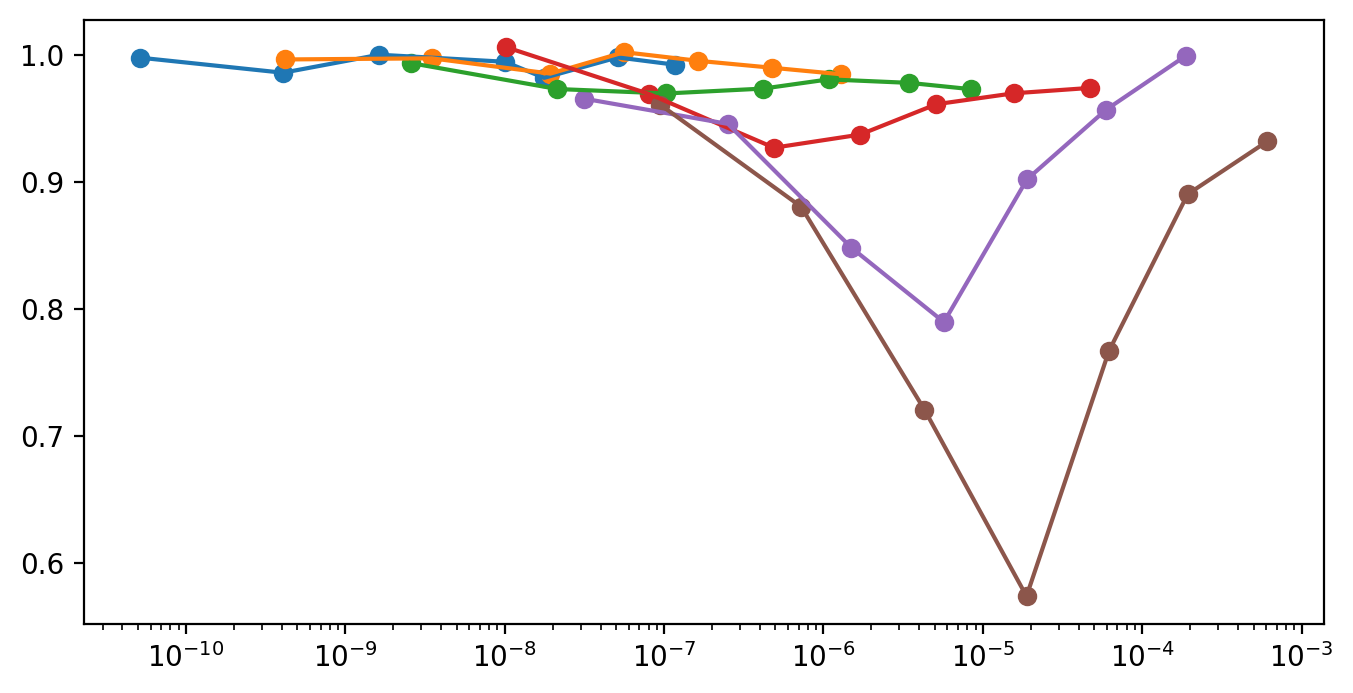

In [115]:
for u in dg['U'].unique():
    dgs = dg.loc[dg.U == u]
    lines = plt.plot(dgs['f_sd']**2, dgs['B'], label=u)
    plt.scatter(dgs['f_sd']**2, dgs['B'], c=lines[0].get_color())

T, Ne, _, V, *_ = bgs_segment_sc16(dg['mu'], dg['sh'], L, rbp, N, return_both=True)


#plt.scatter(dg['U'] / dg['sh'], V, c=np.log10(dg['sh']), marker='+')
plt.semilogx()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'predicted fitness variation')

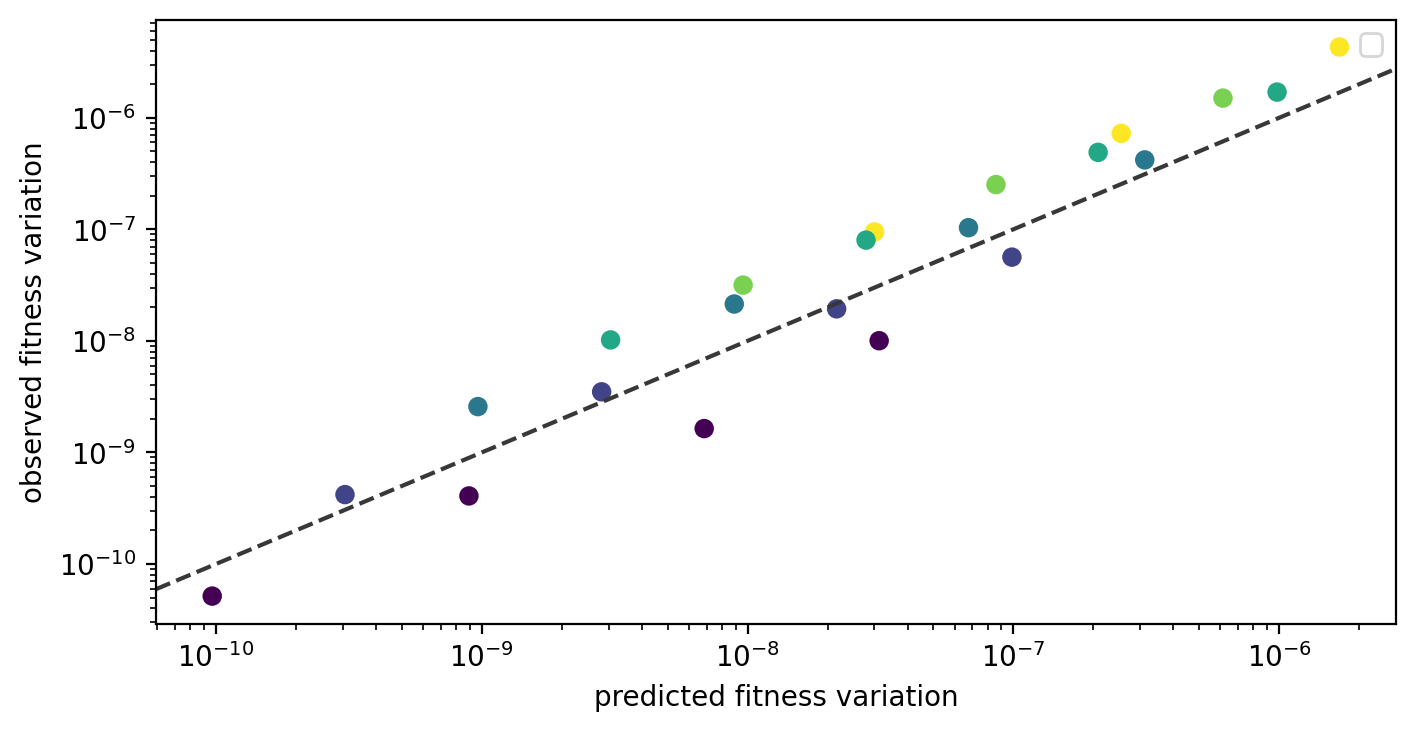

In [180]:
T, Ne, _, V, *_ = bgs_segment_sc16(dg['mu'], dg['sh'], L, rbp, N, return_both=True)
plt.scatter(V, dg['f_sd']**2, c=np.log10(dg['mu']))
plt.legend()
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('observed fitness variation')
plt.xlabel('predicted fitness variation')

Text(0.5, 0, 'predicted fitness variation')

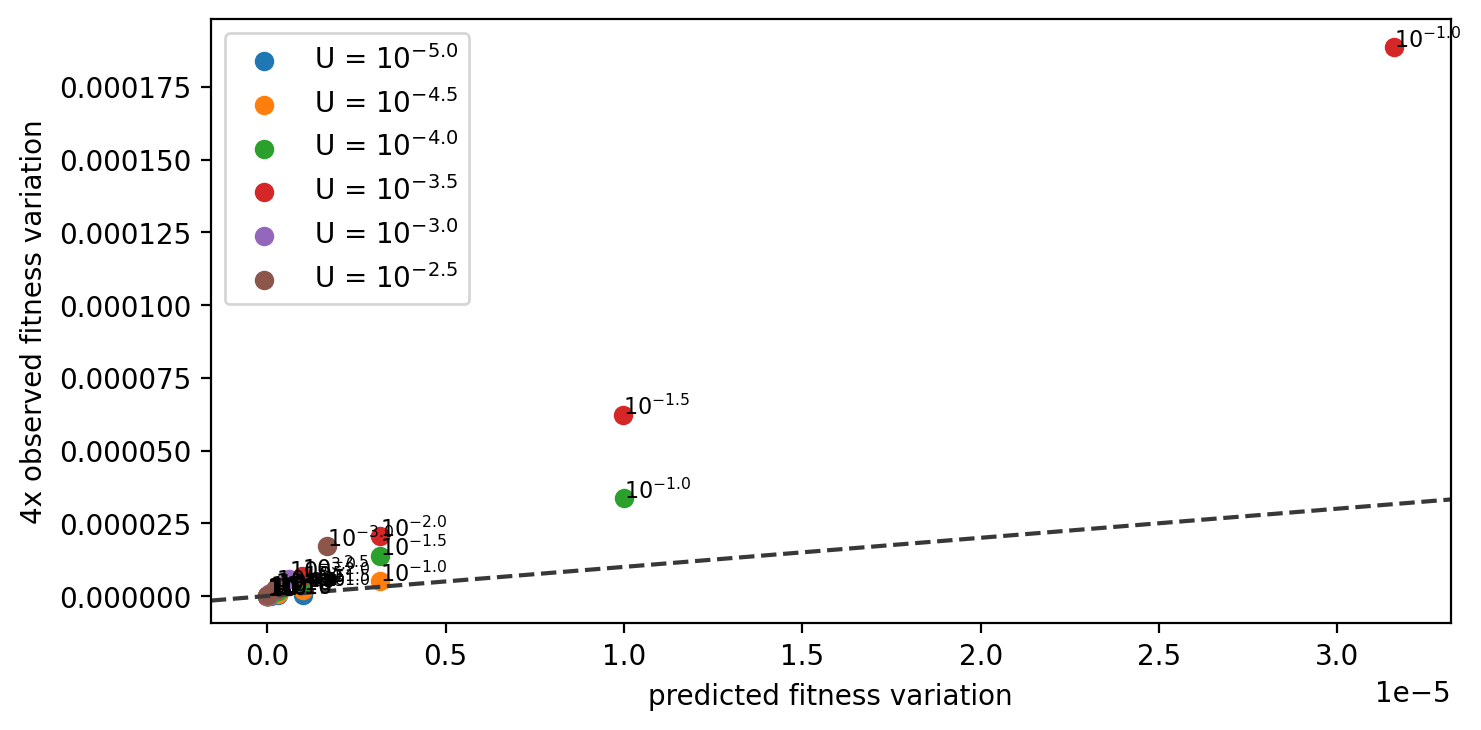

In [17]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = 4 * dgs['f_sd'].values**2 
    
    plt.scatter(V, Vemp, label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)
plt.legend()
plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
#plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

### Fitness Variation

Let's look at empirical fitness variation versus predicted under S&C '16:

Text(0.5, 0, 'predicted fitness variation')

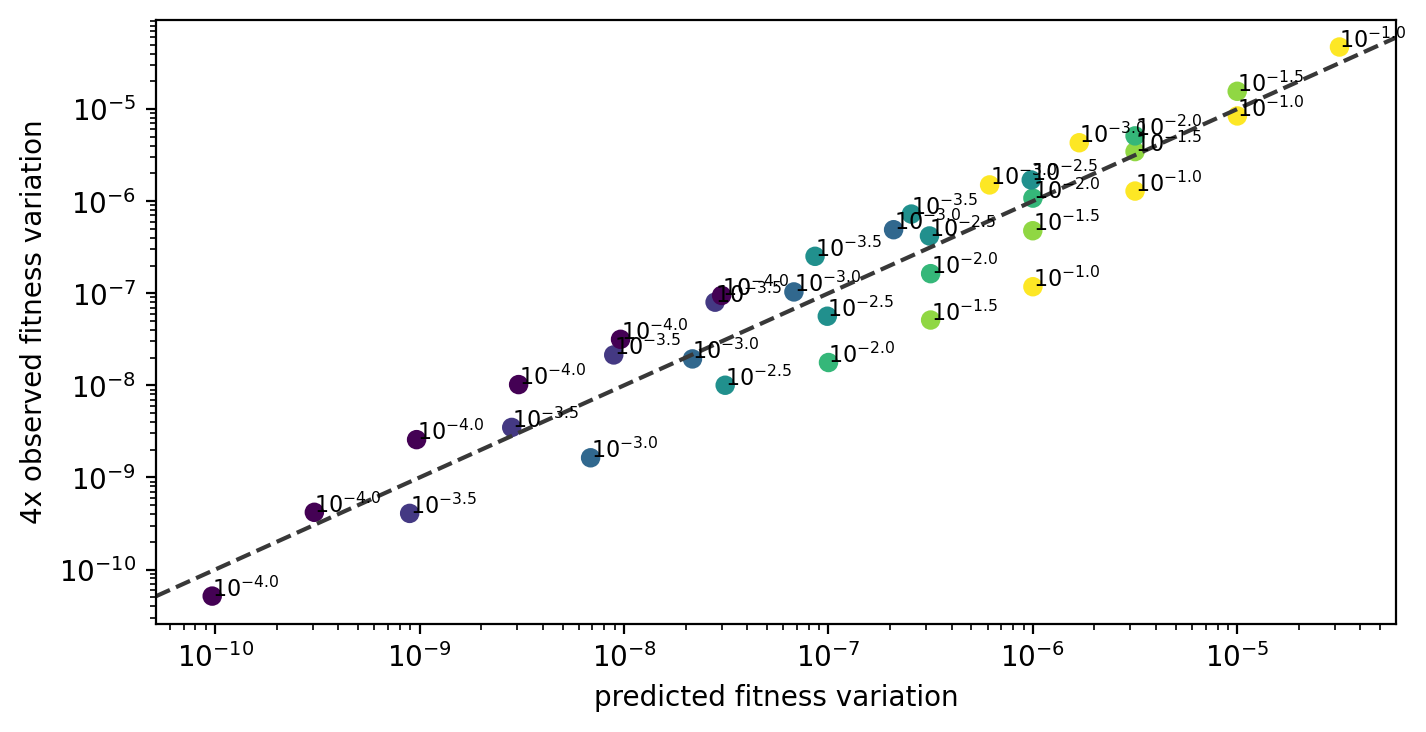

In [21]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = dgs['f_sd'].values**2 
    #Vemp = dgs['sh'].values**2 * dgs['ssh'].values
    plt.scatter(V, Vemp, c = np.log10(dgs['sh']))
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)

plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

Now, let's look at at the genic variance. This is incredibly close; the disparity must be LD.

Text(0.5, 0, 'predicted fitness variation')

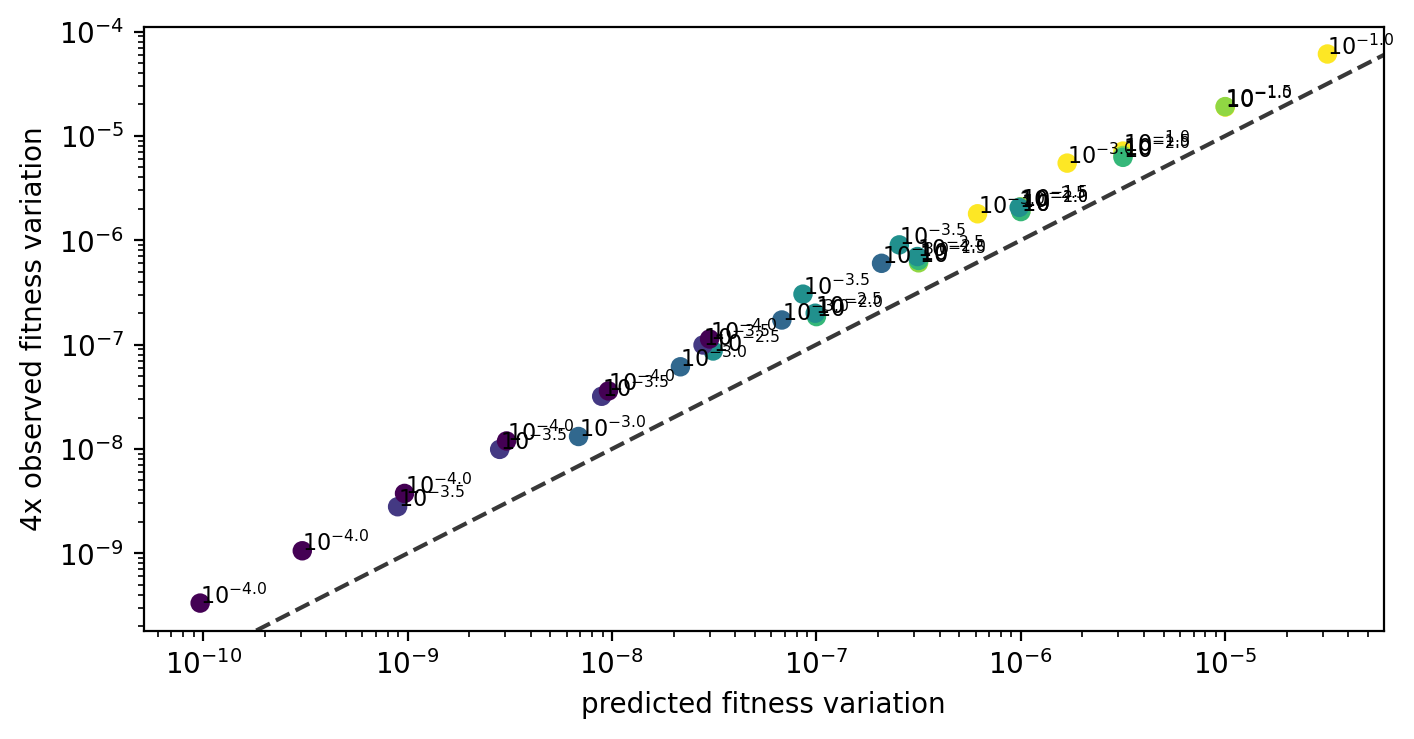

In [25]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    #Vemp = 4 * dgs['f_sd'].values**2 
    Vemp = dgs['sh'].values**2 * dgs['ssh'].values
    plt.scatter(V, Vemp, c = np.log10(dgs['sh']))
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)

plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

Text(0.5, 0, 'predicted fitness variation')

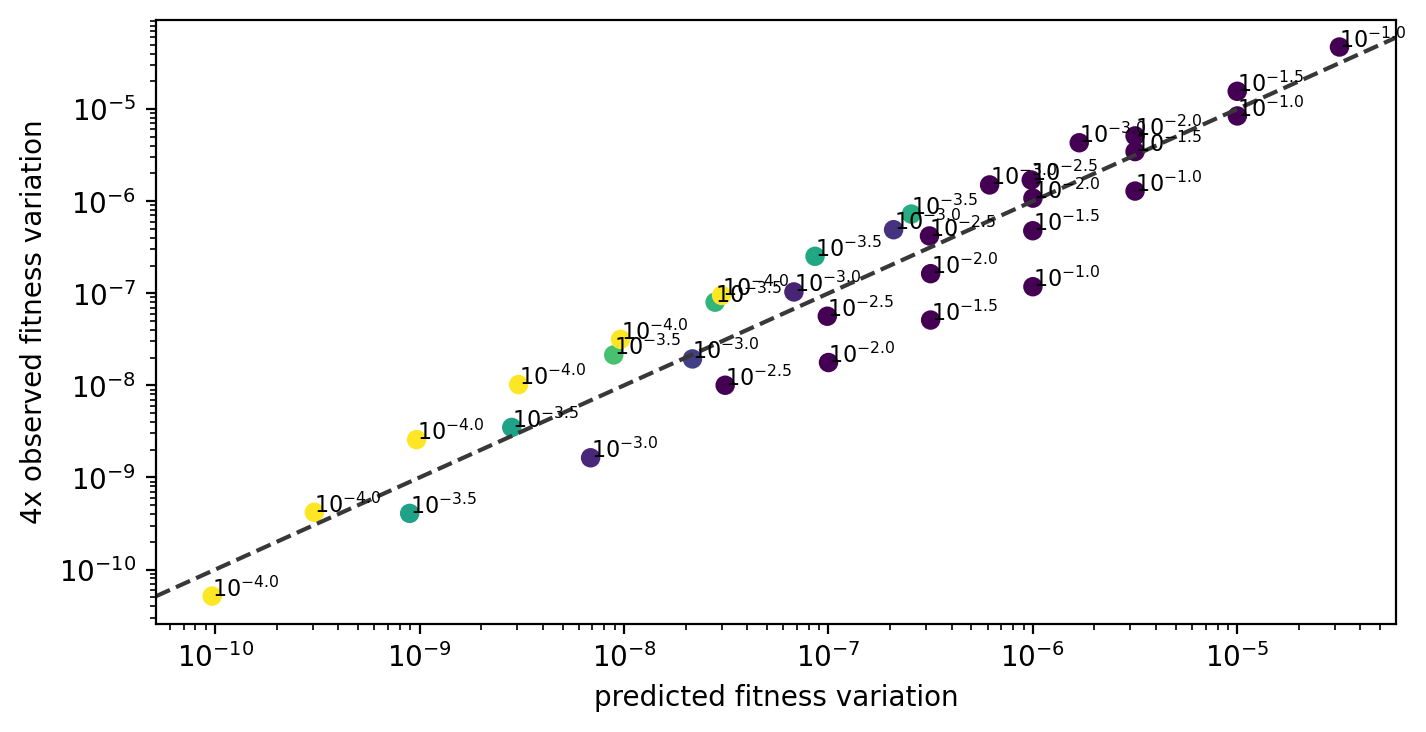

In [26]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = dgs['f_sd'].values**2 
    #Vemp = 4 * dgs['sh'].values**2 * dgs['ssh'].values
    plt.scatter(V, Vemp, c = np.log10(0.1+dgs['R']))
    
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (V[i], Vemp[i]), fontsize=8)

plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.ylabel('4x observed fitness variation')
plt.xlabel('predicted fitness variation')

Text(0.5, 0, 'genic - Va')

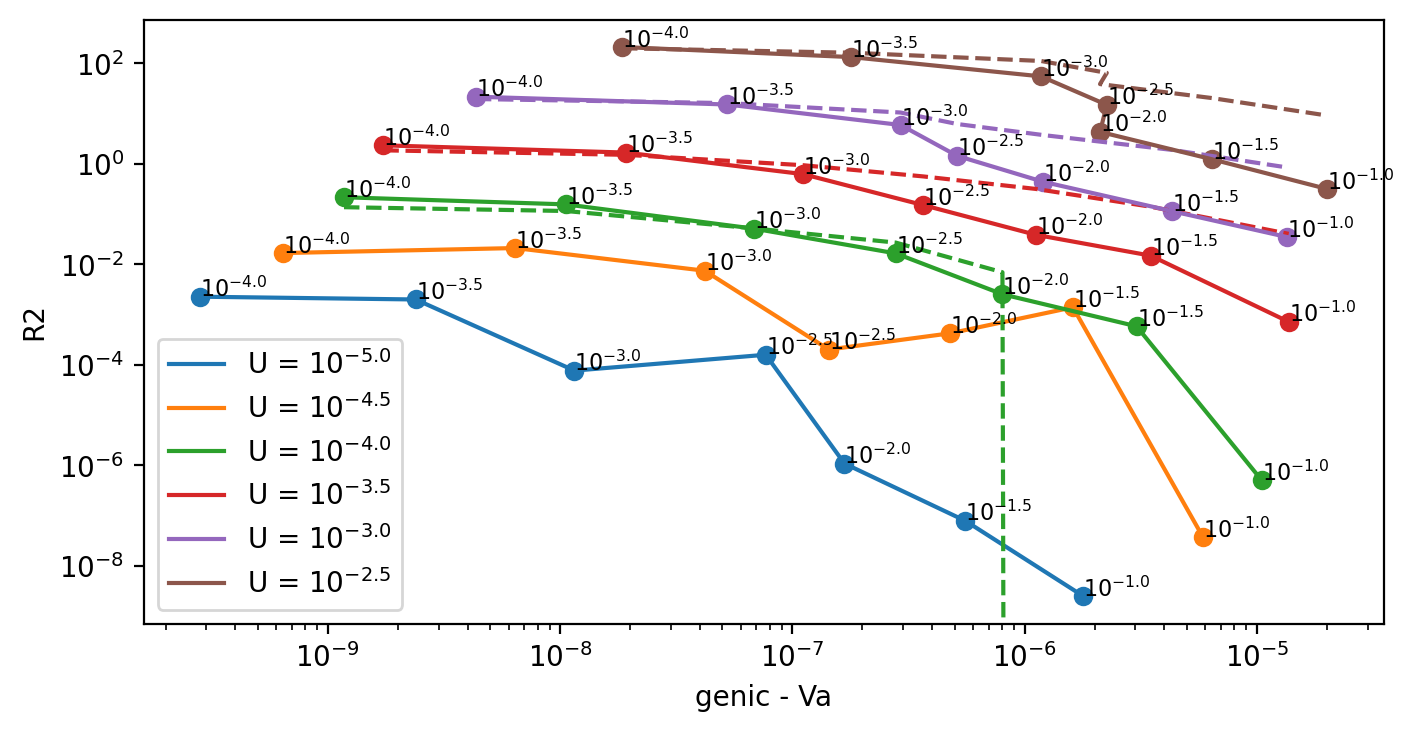

In [32]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    #T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = dgs['f_sd'].values**2 
    Vemp_ssh =  dgs['sh'].values**2 * dgs['ssh'].values
    
    Vdiff = np.abs(Vemp - Vemp_ssh)
    
    lines = plt.plot(Vdiff, dgs['r2sum'], label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    plt.scatter(Vdiff, dgs['r2sum'], c=lines[0].get_color())
    x = Vdiff 
    y = dgs['r2sum'].values
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (x[i], y[i]), fontsize=8)
    n = dgs['ldn']
    multiplier = n * (n-1) * 32
    
    rate = dgs['U'] / dgs['sh']
    #scaler = np.exp(-rate)
    scaler = 1
    plt.plot(Vdiff, neutral_ld(L, rbp, N*scaler) * multiplier, linestyle='dashed', c=lines[0].get_color())
#plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.legend()
plt.loglog()
plt.ylabel('R2')
plt.xlabel('genic - Va')

[]

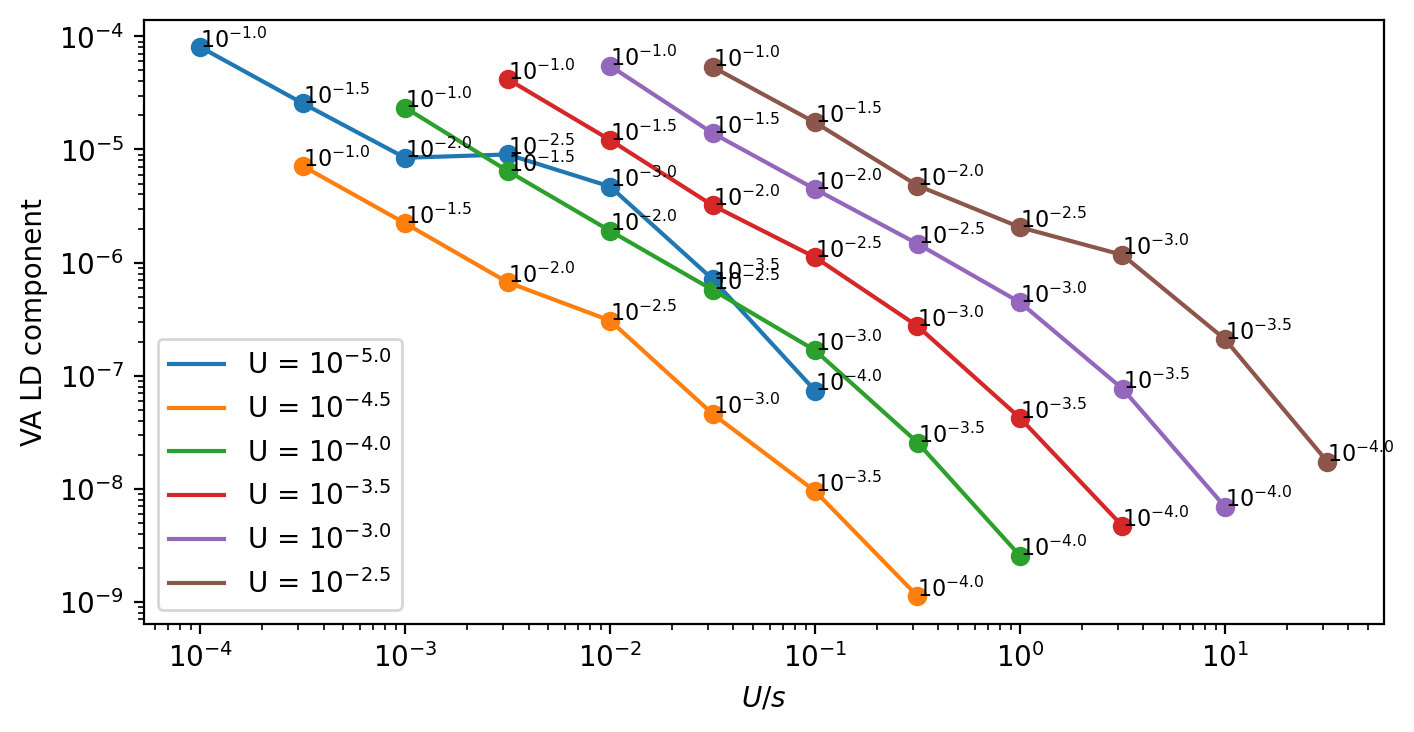

In [66]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    #T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vdiff = Vemp_ssh - Vemp
    Vemp = 4 * dgs['f_sd'].values**2 
    Vemp_ssh = 4 * dgs['sh'].values**2 * dgs['ssh'].values
    x = L * dgs['mu'].values/dgs['sh'].values
    lines = plt.plot(x, Vdiff, label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    plt.scatter(x, Vdiff, c=lines[0].get_color())
    y = Vdiff
    for i in range(len(V)):
        plt.annotate(f"$10^{{{np.round(np.log10(dgs['sh'].values[i]), 2)}}}$", (x[i], y[i]), fontsize=8)
        
plt.legend()
plt.ylabel('VA LD component')    
plt.xlabel('$U/s$')
plt.loglog()

Text(0.5, 0, 'genic - Va')

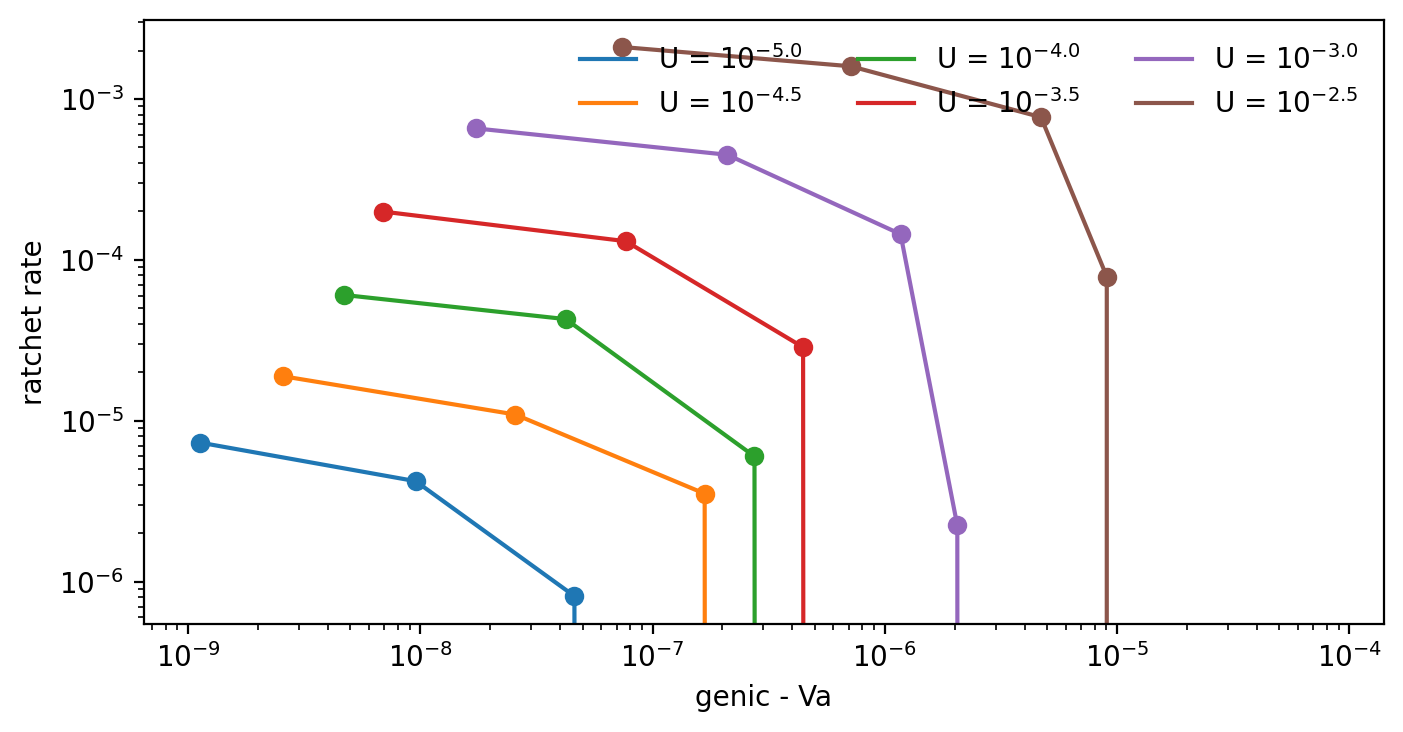

In [33]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]

    #T, Ne, _, V, *_ = bgs_segment_sc16(dgs['mu'], dgs['sh'], L, rbp, N, return_both=True)

    Vemp = 4 * dgs['f_sd'].values**2 
    Vemp_ssh = 4 * dgs['sh'].values**2 * dgs['ssh'].values
    vald = Vemp_ssh - Vemp
    #y = Vemp - Vemp_ssh 
    lines = plt.plot(vald, dgs['R'], label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
    plt.scatter(vald, dgs['R'], c=lines[0].get_color())

#plt.axline((0, 0), slope=1, linestyle='dashed', c='0.22')
plt.loglog()
plt.legend(ncol=3, frameon=False)
plt.ylabel('ratchet rate')
plt.xlabel('genic - Va')

Text(0.5, 0, 'R')

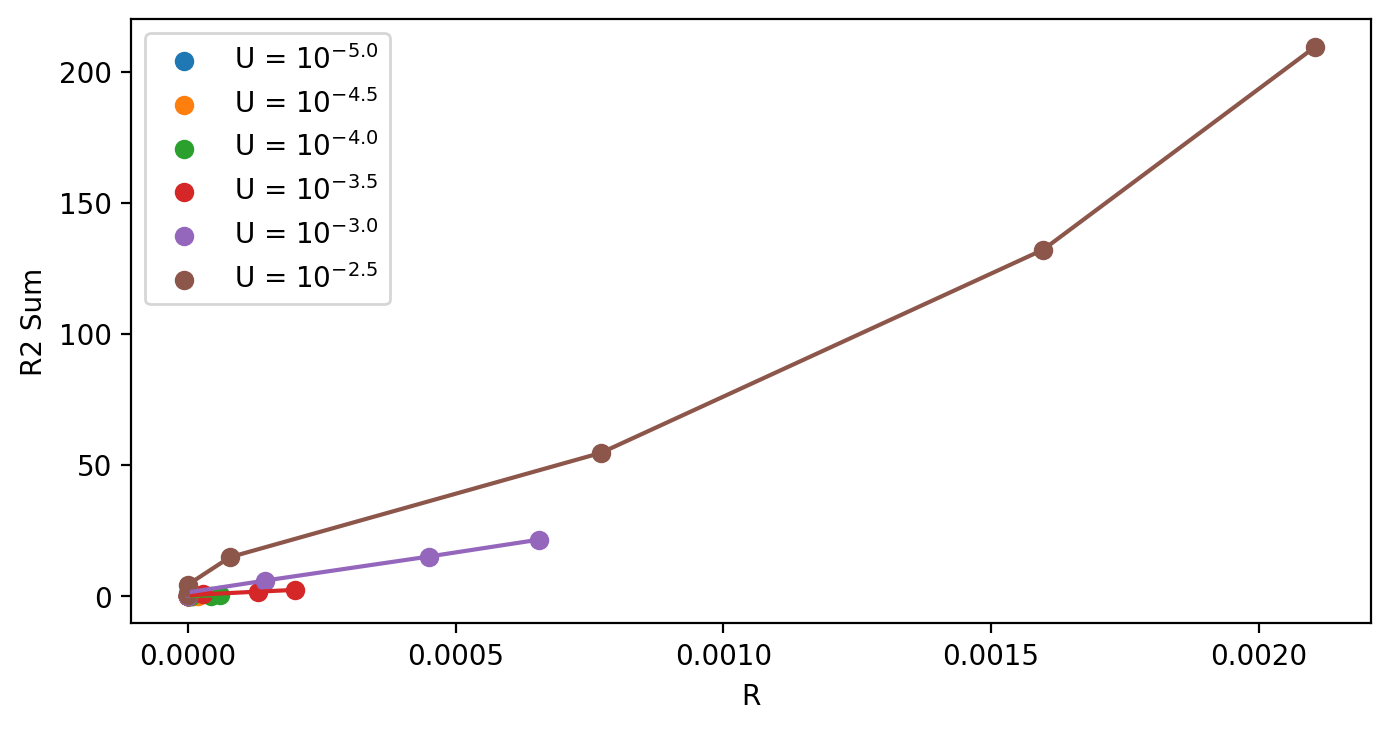

In [89]:
for u in dg['U'].unique():
    dgs = dg.loc[dg['U'] == u]
    plt.plot(dgs['R'], dgs['r2sum'])
    plt.scatter(dgs['R'], dgs['r2sum'], label=f"U = $10^{{{np.round(np.log10(u), 2)}}}$")
plt.legend()
#plt.semilogx()
plt.ylabel('R2 Sum')
plt.xlabel('R')

## Notes on heterozygosity

S&C (1995, 2016) use a strange heterozygosity that I cannot find a good approximation to. Theirs is:


$$
H \approx 2 \mu \sum_{i=1}^\infty \prod_{t=1}^i \left(1-\frac{1}{2 N_e(t)} \right)
$$


The expected pairwise diversity under a coalescent model would be, 

$$
 \mathrm{E}(\pi) = 2 \mu \sum_{i=1}^\infty \frac{i}{2 N_e(t)}\prod_{t=1}^{i-1} \left(1-\frac{1}{2 N_e(t)}\right)
$$

Which is similar to the heterozygosity at a locus, 

$$ 
 \mathcal{H} = 1 - \sum_{i=1}^\infty  \frac{(1-\mu)^{2i}}{2 N_e(t)}\prod_{t=1}^{i-1} \left(1-\frac{1}{2 N_e(t)}\right)
$$


In [4]:
def random_Ne(center, scale, n=10):
    x = np.random.normal(center, scale, int(center*n)).astype(int)
    assert all(x > 0)
    return x

In [5]:
def H(Ne, mu):
    return 1-np.sum([0.5*((1-mu)**(2*i))/Ne[i] * np.prod((1-0.5/Ne[:(i-1)])) for i in range(len(Ne))])

def SC16_H(Ne, mu):
    return 2*mu * np.sum([np.prod((1-0.5/Ne[:i])) for i in range(len(Ne))])

def coal_H(Ne, mu):
    return 2*mu * np.sum([i/Ne[i] * np.prod((1-0.5/Ne[:(i-1)])) for i in range(len(Ne))])

In [6]:
Ne = random_Ne(1000, 100)

mu = 1e-8

H(Ne, mu), SC16_H(Ne, mu), coal_H(Ne, mu)

(0.006460383551897819, 3.933703371162901e-05, 7.612125319053593e-05)

The coalescent and S&C heterozygosities are relatively close; the classic heterozygosity is off.

In [7]:
mu = 1e-5

H(Ne, mu), SC16_H(Ne, mu), coal_H(Ne, mu)

(0.04315004763483077, 0.03933703371162901, 0.07612125319053595)

Note though, that when mutation rate are higher (e.g. in a locus), the values are comparable.

Text(0.5, 0, 'ratchet rate')

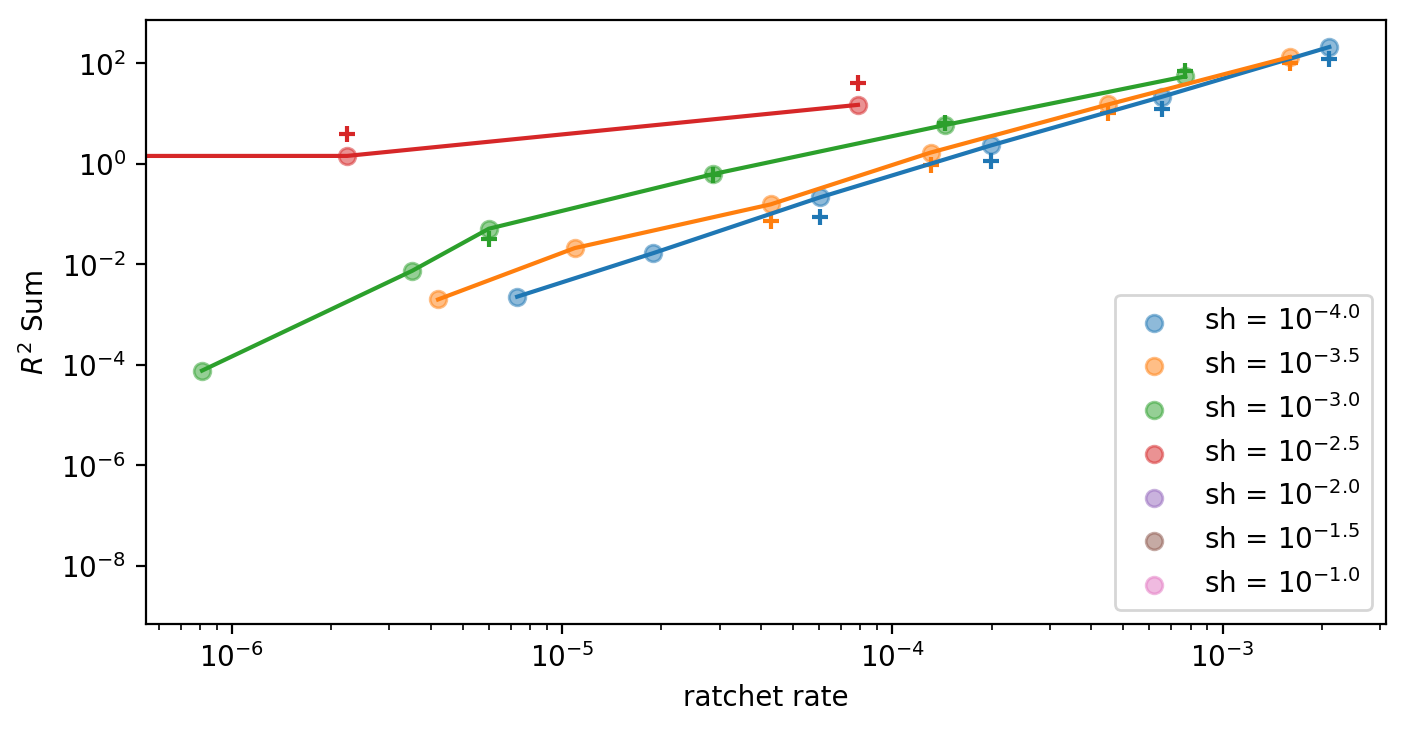

In [91]:
L = 1000000

for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    lines = plt.plot(dgs['R'], dgs['r2sum'])
    plt.scatter(dgs['R'], dgs['r2sum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$", alpha=0.5)
    n = dgs['ldn']
    # NOTE: factor of two!
    plt.scatter(dgs['R'], neutral_ld(L, 1e-8, 1000) * 2 * n * (n-1), c=lines[0].get_color(), marker='+')
plt.legend()
plt.loglog()
plt.ylabel('$R^2$ Sum')
plt.xlabel('ratchet rate')

[]

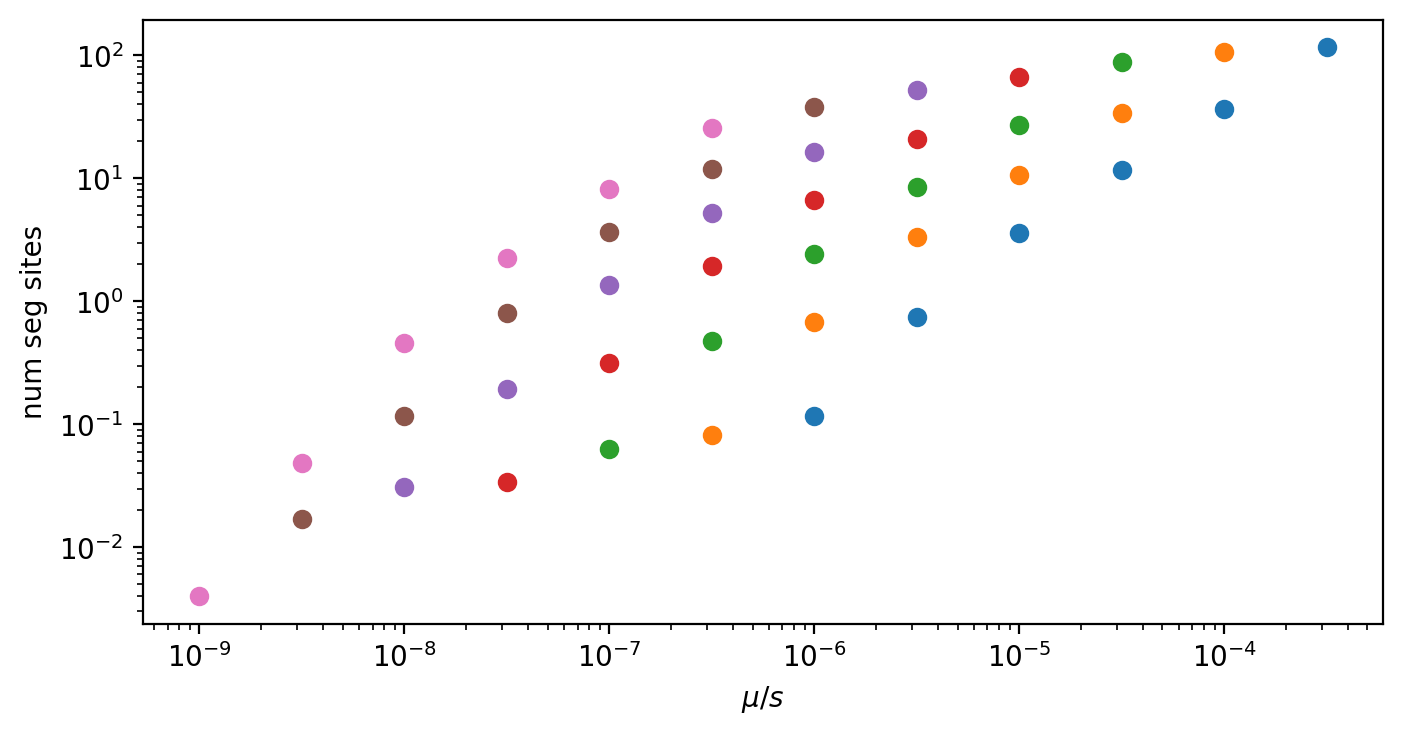

In [92]:
for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    plt.scatter(dgs['mu']/dgs['sh'], dgs['ldn'])
    #plt.plot(dgs['mu']/dgs['sh'], dgs['mu']/dgs['sh'])
plt.xlabel('$\mu/s$')
plt.ylabel('num seg sites')
plt.loglog()

[]

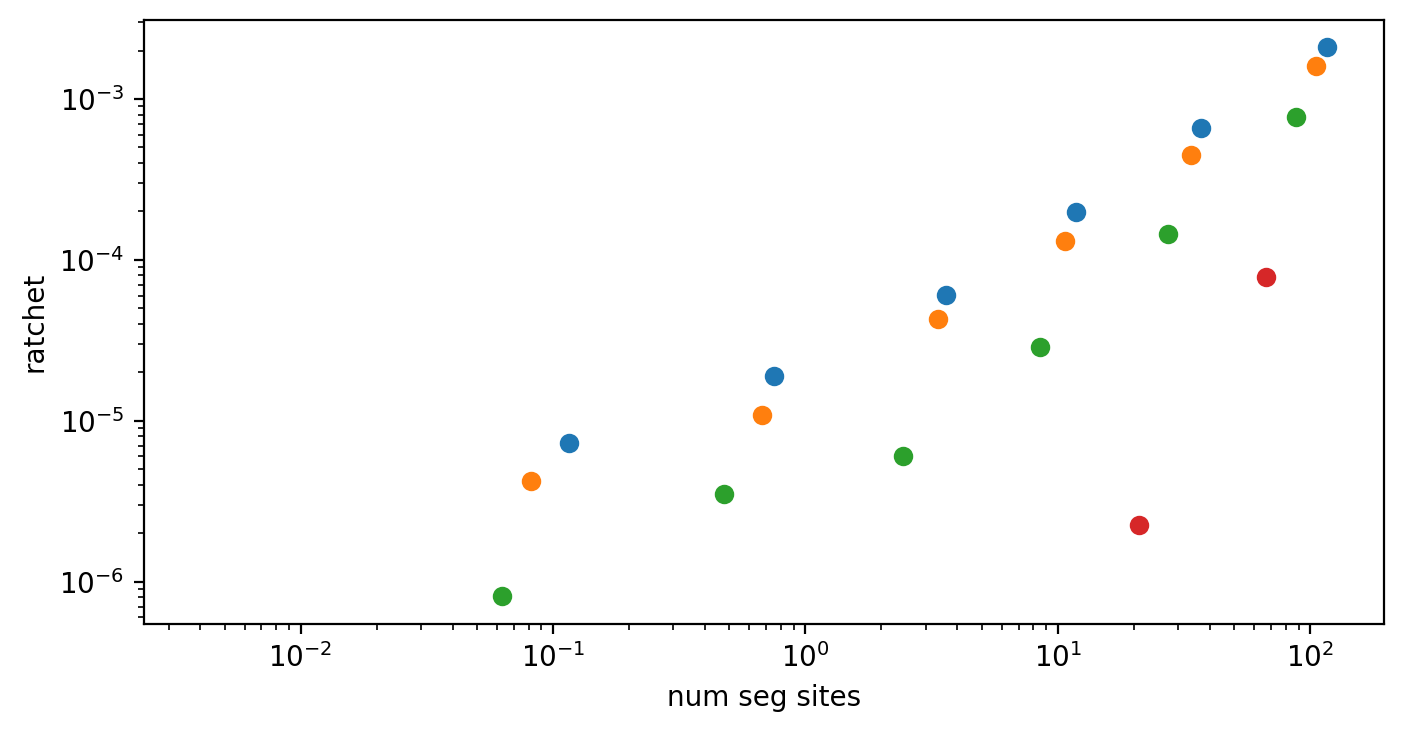

In [93]:
for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    plt.scatter(dgs['ldn'], dgs['R'])
    #plt.plot(dgs['mu']/dgs['sh'], dgs['mu']/dgs['sh'])
plt.xlabel('num seg sites')
plt.ylabel('ratchet')
plt.loglog()

Text(0.5, 0, 'R')

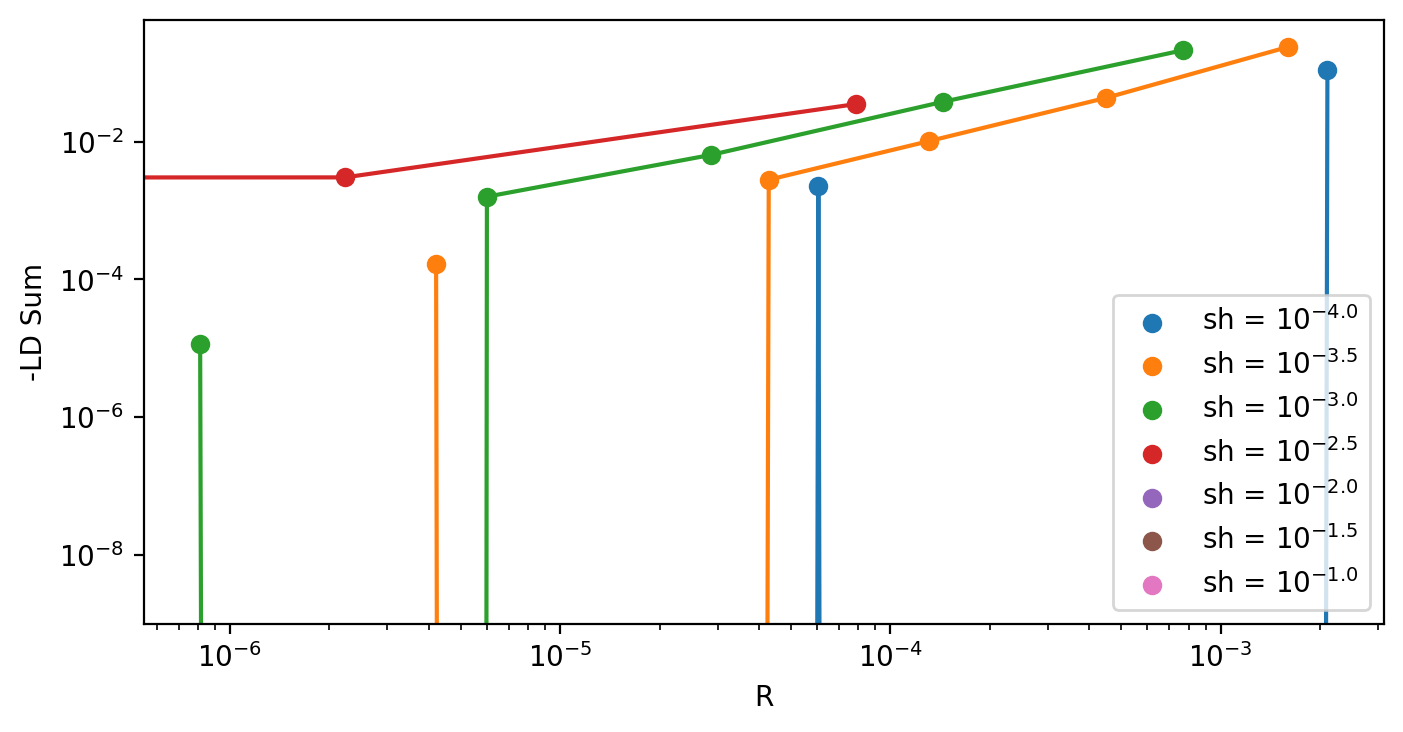

In [94]:

for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    lines = plt.plot(dgs['R'], -dgs['ldsum'])
    plt.scatter(dgs['R'], -dgs['ldsum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$")
    n = dgs['ldn']
    #plt.scatter(dgs['R'], neutral_ld(L, 1e-8, 1000) * 2 * n * (n-1), c=lines[0].get_color(), alpha=0.1)
plt.legend()
plt.loglog()
plt.ylabel('-LD Sum')
plt.xlabel('R')

Text(0.5, 0, 'ratchet rate')

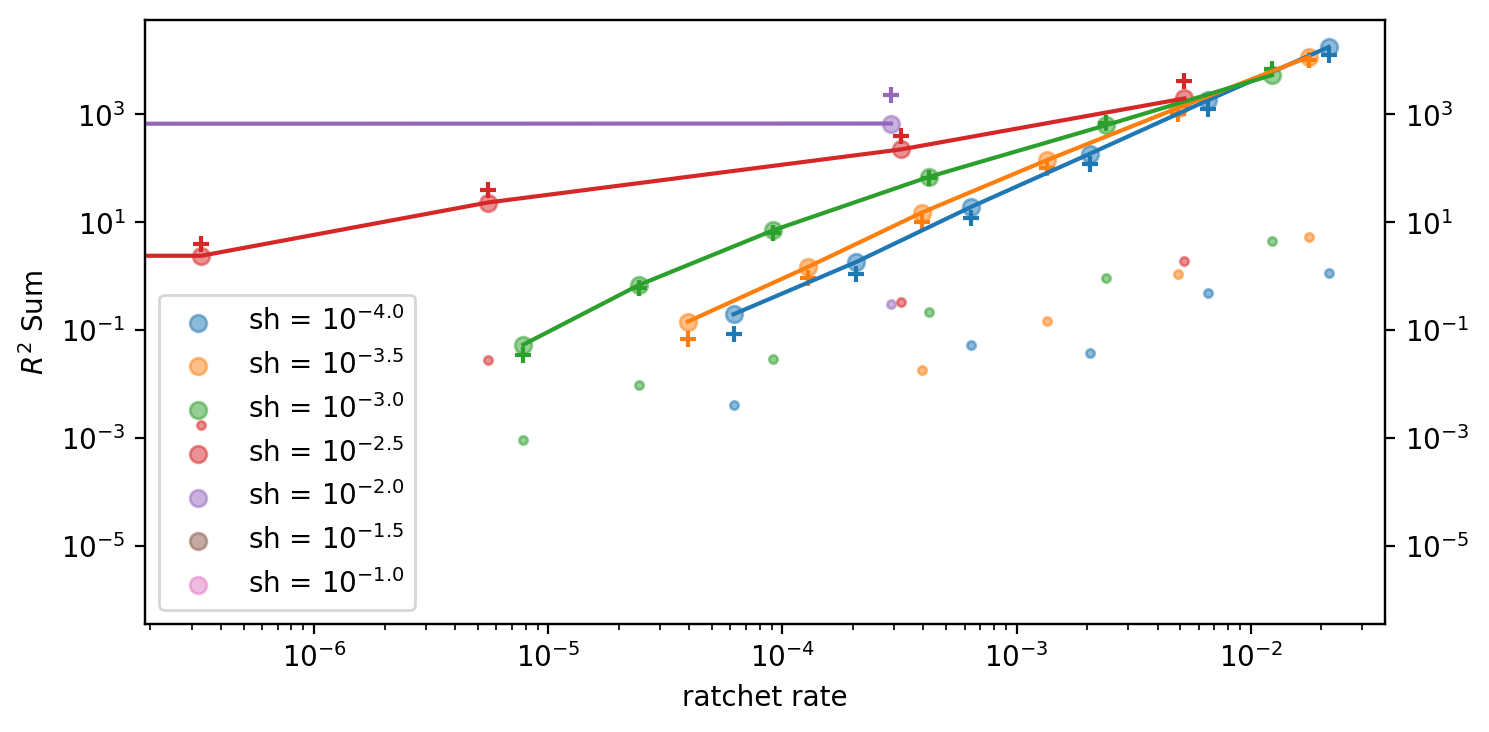

In [105]:
L = 1000000

f, ax = plt.subplots()
ax2 = ax.twinx()

for s in dg['sh'].unique():
    dgs = dg.loc[dg['sh'] == s]
    lines = plt.plot(dgs['R'], dgs['r2sum'])
    ax.scatter(dgs['R'], dgs['r2sum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$", alpha=0.5)
    n = dgs['ldn']
    # NOTE: factor of two!
    ax.scatter(dgs['R'], neutral_ld(L, 1e-8, 1000) * 2 * n * (n-1), c=lines[0].get_color(), marker='+')
    
    ax2.scatter(dgs['R'], -dgs['ldsum'], label=f"sh = $10^{{{np.round(np.log10(s), 2)}}}$", marker='.', alpha=0.5)
ax.legend()
ax.loglog()
ax2.loglog()

ax.set_ylabel('$R^2$ Sum')
ax.set_xlabel('ratchet rate')